In [1]:
import os
import subprocess

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astropy.table import Table, vstack
from astropy.io import ascii
from astropy.io import fits
import astropy.units as u
from astropy.coordinates import SkyCoord


In [2]:
imageDirectory = '/data/mj1e16/kepler/cal/'
medianDir = '/data/mj1e16/kepler/newDiff/'

# imageDirectory = '/media/mj1e16/PP AV-TV/keplerCal/'
# medianDir = '/media/mj1e16/PP AV-TV/medians/'

In [3]:
dirlist = os.listdir(imageDirectory)
dirlist = [x for x in dirlist if x[0] != '.']
imagelist = [imageDirectory+x for x in dirlist]

In [4]:
def correctExtensionOrder(imageName):
    hdu_list = fits.open(imageName)
    extensionOrder = np.zeros(len(hdu_list))
    for channel in range(1,len(hdu_list)):
        hdr = hdu_list[channel].header
        location = hdr['SKYGROUP'] # independant location
        extensionOrder[location] = channel # ordered from 0-84 channel with extension in place of name
    return extensionOrder

In [5]:
extensionOrders = []
for image in imagelist:
    extensionOrders.append(correctExtensionOrder(image))

In [6]:
def getAllccds(imagelist,pos,extensionOrders):
    names = []
    for x in range(len(imagelist)):
        extension = int(extensionOrders[x][pos])
        names.append(imagelist[x]+'[{}]'.format(extension))
    return names

In [7]:
def getIndiExt(image,imagelist,extensionOrders,imDir=imageDirectory):
    loc1 = image.find('[')
    loc2  = image.find(']')
    imagename = imDir+image[:loc1]
    pos = image[loc1+1:loc2]
    imagepos = imagelist.index(imagename)
    #extensionOrders[imagepos] = extensionOrders[imagepos].tolist()
    XO = [str(int(x)) for x in extensionOrders[imagepos]]
    indiExt = XO.index(pos)
    return [indiExt,pos]

In [34]:
def findMatchesNoCondition(tab,ra,dec,max_sep = 2.5 * u.arcsec):
    
    df = tab.to_pandas()
    
    ra1 =[ra,ra]
    dec1 = [dec,dec]
    
    number2 = tab['OBJECT INDEX'] # difference image
    ra2 = tab['RA']
    dec2 = tab['DEC']    
    
    cat1 = SkyCoord(ra=ra1*u.degree, dec=dec1*u.degree)
    cat2 = SkyCoord(ra=ra2*u.degree, dec=dec2*u.degree)
    
    idx, d2d, d3d = cat2.match_to_catalog_sky(cat1)
    sep_constraint = d2d < max_sep
    objectsFound = number2[sep_constraint]
    matchdf = df[df['OBJECT INDEX'].isin(objectsFound)]
    matchtab = Table.from_pandas(matchdf)
    return matchtab

In [9]:
def findDate(imageName,channel):
    hdu_list = fits.open(imageName)
    hdr = hdu_list[int(channel)].header
    date = hdr['MJDSTART'] # independant location
    return date

In [10]:
def makeDS9RegFile(sexTabList,fileNameBase,tabType):
    for tables in range(len(sexTabList)):
        if tabType == 'dao':
            xcoords = sexTabList[tables]['xcentroid']
            ycoords = sexTabList[tables]['ycentroid']
        elif tabType == 'sex':
            xcoords = sexTabList[tables]['X_IMAGE']
            ycoords = sexTabList[tables]['Y_IMAGE']
        elif tabType == 'iraf':
            xcoords = sexTabList[tables]['X_POS']
            ycoords = sexTabList[tables]['Y_POS']        
        else:
            print('tab type error')
            break
        bigString = 'global color=lightgreen\nimage\n'
        for x in range(len(xcoords)):
            bigString += 'circle({},{},5)\n'.format(xcoords[x],ycoords[x])
        fileName = fileNameBase + '.reg'
        with open(fileName,'w') as f:
            f.write(bigString)
#         print(fileName)
#         print(os.listdir('.'))

In [30]:
def makeLightCurves(origTab):
    allTabs = []
    imNames = []
    mag = []
    #date = []
    imageReDo = []
    fullExt = []
    otherfullExt = []
    for im in range(len(origTab)):
        ra = origTab['RA'][im]
        dec=origTab['DEC'][im]
        image = origTab['IMAGE_NAME'][im]
        indiext = getIndiExt(image,imagelist,extensionOrders)[0]
        nonindiext = getIndiExt(image,imagelist,extensionOrders)[1]
        allNames = getAllccds(imagelist,indiext,extensionOrders)
        testmatch = []
        magone = []
        imNameOne = []
        extensions = []
        for x in range(len(allNames)):
            loc1 = allNames[x].find(imageDirectory)+len(imageDirectory)
            imNameOnly = allNames[x][loc1:]
            loc2 = imNameOnly.find('[')+1
            loc3 = imNameOnly.find(']')
            imextOnly = imNameOnly[loc2:loc3]
            oneimTab = ascii.read('/home/mj1e16/outTablesImproved/imagecsv/'+imNameOnly+'.csv')
            oneimTab['OBJECT INDEX'] = range(len(oneimTab))
            if len(testmatch) == 0:
                try:
                    testmatch = findMatchesNoCondition(oneimTab,ra,dec)
                    if len(testmatch) != 0:
                        onemag = testmatch['MAG_BEST'][0]
                        magone.append(onemag)
                        imNameOne.append(imNameOnly)
                        extensions.append(imextOnly)
                        #extensionsOther.append(indiext)
                        print(imNameOnly,imextOnly)
        #                 mag.append(testmatch['MAG_BEST'][0])
                        #imNames.append(imNameOnly)
                except:
                    imageReDo.append(imNameOnly)
                    print('Redo file '+imNameOnly)
            else:
                try:
                    oneim = findMatchesNoCondition(oneimTab,ra,dec)

                except:
                    imageReDo.append(imNameOnly)
                    print('Redo file '+imNameOnly)
                if len(oneim) != 0:
                    onemag = oneim['MAG_BEST'][0]
                    magone.append(onemag)
                    imNameOne.append(imNameOnly)
                    extensions.append(imextOnly)
                    #extensionsOther.append(indiext)
                    print(imNameOnly)
                    #print(testmatch['IMAGE_NAME'],oneim['IMAGE_NAME'])
                    testmatch = vstack([testmatch,oneim])


        fullExt.append(extensions) 
        #otherfullExt.append(extensionsOther)
        imNames.append(imNameOne)
        mag.append(magone)

        #allTabs.append(testmatch)
        print('index {}'.format(im),len(testmatch))
    datesfull = []
    for x in range(len(imNames)):
        #if len(imNames[x]) > 1:
        dates = []
        for y in range(len(imNames[x])):
            image = imNames[x][y]
            #print(image)
            loc1 = image.find('[')
            loc2  = image.find(']')
            imagename = imageDirectory+image[:loc1]
            #print(imagename)
            pos = image[loc1+1:loc2]
            date = findDate(imagename,pos)
            dates.append(date)
        datesfull.append(dates)
        
    isThereAmatch = [0 for x in mag]
    colours = ['bo','go','ro','ko']
    coloursAlt = ['b*','g*','r*','k*']
    for x in range(len(datesfull)):
        if len(datesfull[x]) > 1:
            if isThereAmatch[x] ==0:
                for y in range(len(datesfull[x])):
                    exts = list(set(fullExt[x]))
                    #print(exts)
                    pos = exts.index(fullExt[x][y])
                    colour = colours[pos]
    #                 print(pos)
    #                 print(colour)
    #                 print(len(datesfull[x]),len(mag[x]))
                    plt.plot(datesfull[x][y],mag[x][y],colours[pos])
            else:
                for y in range(len(datesfull[x])):
                    exts = list(set(fullExt[x]))
                    pos = exts.index(fullExt[x][y])
                    #print(exts)
                    colour = colours[pos]
                    plt.plot(datesfull[x][y],mag[x][y],coloursAlt[pos])

            plt.ylabel('MAG')
            plt.xlabel('MJD')
            plt.gca().invert_yaxis()
            #plt.legend()
            plt.savefig('/home/mj1e16/thesisFigures/lc_{}_{}_{}.png'.format(origTab['RA'][x], origTab['DEC'][x],origTab['IMAGE_NAME'][x]))
            plt.show()
            print(origTab['RA'][x], origTab['DEC'][x],origTab['IMAGE_NAME'][x])
    return [datesfull,mag,coloursAlt,ra,dec]

('kplr2012121122500_ffi-cal.fits[15]', '15')
kplr2011240181752_ffi-cal.fits[75]
kplr2010111125026_ffi-cal.fits[15]
kplr2011177110110_ffi-cal.fits[15]
kplr2013011160902_ffi-cal.fits[71]
kplr2011271191331_ffi-cal.fits[75]
kplr2010174164113_ffi-cal.fits[15]
kplr2012088132324_ffi-cal.fits[11]
kplr2010265195356_ffi-cal.fits[75]
kplr2009114174833_ffi-cal.fits[15]
kplr2011303191211_ffi-cal.fits[71]
kplr2011334181008_ffi-cal.fits[71]
kplr2009260000800_ffi-cal.fits[75]
kplr2009114204835_ffi-cal.fits[15]
kplr2012341215621_ffi-cal.fits[71]
kplr2009115080620_ffi-cal.fits[15]
kplr2010296192119_ffi-cal.fits[71]
kplr2013038133130_ffi-cal.fits[11]
kplr2011116104002_ffi-cal.fits[15]
kplr2010140101631_ffi-cal.fits[15]
kplr2010019225502_ffi-cal.fits[11]
kplr2012310200152_ffi-cal.fits[71]
kplr2013098115308_ffi-cal.fits[11]
kplr2010020005046_ffi-cal.fits[11]
kplr2010234192745_ffi-cal.fits[75]
kplr2012179140901_ffi-cal.fits[15]
kplr2009351005245_ffi-cal.fits[71]
kplr2011208112727_ffi-cal.fits[75]
kplr200923

kplr2012242195726_ffi-cal.fits[60]
kplr2013065115251_ffi-cal.fits[28]
kplr2009115053616_ffi-cal.fits[20]
kplr2009115131122_ffi-cal.fits[20]
kplr2012032101442_ffi-cal.fits[28]
kplr2010049182302_ffi-cal.fits[28]
kplr2012060123308_ffi-cal.fits[28]
('index 5', 45)
('kplr2012121122500_ffi-cal.fits[25]', '25')
kplr2009322233047_ffi-cal.fits[57]
kplr2010111125026_ffi-cal.fits[25]
kplr2011177110110_ffi-cal.fits[25]
kplr2011271191331_ffi-cal.fits[17]
kplr2010174164113_ffi-cal.fits[25]
kplr2009114174833_ffi-cal.fits[25]
kplr2011334181008_ffi-cal.fits[57]
kplr2009114204835_ffi-cal.fits[25]
kplr2012341215621_ffi-cal.fits[57]
kplr2009115080620_ffi-cal.fits[25]
kplr2013038133130_ffi-cal.fits[65]
kplr2011116104002_ffi-cal.fits[25]
kplr2010019225502_ffi-cal.fits[65]
kplr2012310200152_ffi-cal.fits[57]
kplr2010020005046_ffi-cal.fits[65]
kplr2012179140901_ffi-cal.fits[25]
kplr2009351005245_ffi-cal.fits[57]
kplr2011208112727_ffi-cal.fits[17]
kplr2012211123923_ffi-cal.fits[17]
kplr2011053174401_ffi-cal.fit

kplr2011024134926_ffi-cal.fits[50]
Redo file kplr2012151105138_ffi-cal.fits[6]
kplr2012151105138_ffi-cal.fits[6]
kplr2009115002613_ffi-cal.fits[6]
kplr2009116035924_ffi-cal.fits[6]
kplr2009292020429_ffi-cal.fits[78]
kplr2010203012215_ffi-cal.fits[34]
kplr2012004204112_ffi-cal.fits[78]
kplr2012277203051_ffi-cal.fits[34]
kplr2010356020128_ffi-cal.fits[78]
kplr2010326181728_ffi-cal.fits[78]
kplr2012242195726_ffi-cal.fits[34]
kplr2013065115251_ffi-cal.fits[50]
kplr2012032101442_ffi-cal.fits[50]
kplr2010049182302_ffi-cal.fits[50]
kplr2012060123308_ffi-cal.fits[50]
('index 11', 47)
('kplr2012121122500_ffi-cal.fits[47]', '47')
kplr2009322233047_ffi-cal.fits[39]
kplr2010111125026_ffi-cal.fits[47]
kplr2013011160902_ffi-cal.fits[39]
kplr2012088132324_ffi-cal.fits[63]
kplr2009114174833_ffi-cal.fits[47]
kplr2011303191211_ffi-cal.fits[39]
kplr2011334181008_ffi-cal.fits[39]
kplr2009260000800_ffi-cal.fits[23]
kplr2009114204835_ffi-cal.fits[47]
kplr2012341215621_ffi-cal.fits[39]
kplr2009115080620_ffi-

kplr2010049182302_ffi-cal.fits[65]
kplr2012060123308_ffi-cal.fits[65]
('index 18', 30)
('kplr2012121122500_ffi-cal.fits[15]', '15')
kplr2011240181752_ffi-cal.fits[75]
kplr2009322233047_ffi-cal.fits[71]
kplr2010111125026_ffi-cal.fits[15]
kplr2011177110110_ffi-cal.fits[15]
kplr2013011160902_ffi-cal.fits[71]
kplr2011271191331_ffi-cal.fits[75]
kplr2010174164113_ffi-cal.fits[15]
kplr2012088132324_ffi-cal.fits[11]
kplr2010265195356_ffi-cal.fits[75]
kplr2009114174833_ffi-cal.fits[15]
kplr2011303191211_ffi-cal.fits[71]
kplr2009260000800_ffi-cal.fits[75]
kplr2009114204835_ffi-cal.fits[15]
kplr2012341215621_ffi-cal.fits[71]
kplr2009115080620_ffi-cal.fits[15]
kplr2010296192119_ffi-cal.fits[71]
kplr2013038133130_ffi-cal.fits[11]
kplr2010140101631_ffi-cal.fits[15]
kplr2010019225502_ffi-cal.fits[11]
kplr2012310200152_ffi-cal.fits[71]
kplr2013098115308_ffi-cal.fits[11]
kplr2010020005046_ffi-cal.fits[11]
kplr2010234192745_ffi-cal.fits[75]
kplr2012179140901_ffi-cal.fits[15]
kplr2009351005245_ffi-cal.fi

kplr2010111125026_ffi-cal.fits[47]
kplr2013011160902_ffi-cal.fits[39]
kplr2012088132324_ffi-cal.fits[63]
kplr2009114174833_ffi-cal.fits[47]
kplr2011303191211_ffi-cal.fits[39]
kplr2011334181008_ffi-cal.fits[39]
kplr2009260000800_ffi-cal.fits[23]
kplr2009114204835_ffi-cal.fits[47]
kplr2012341215621_ffi-cal.fits[39]
kplr2009115080620_ffi-cal.fits[47]
kplr2010296192119_ffi-cal.fits[39]
kplr2013038133130_ffi-cal.fits[63]
kplr2011116104002_ffi-cal.fits[47]
kplr2010140101631_ffi-cal.fits[47]
kplr2010019225502_ffi-cal.fits[63]
kplr2013098115308_ffi-cal.fits[63]
kplr2010020005046_ffi-cal.fits[63]
kplr2009351005245_ffi-cal.fits[39]
kplr2010078174524_ffi-cal.fits[63]
kplr2011053174401_ffi-cal.fits[63]
kplr2011145152723_ffi-cal.fits[47]
kplr2011024134926_ffi-cal.fits[63]
kplr2012151105138_ffi-cal.fits[47]
kplr2009115002613_ffi-cal.fits[47]
kplr2009116035924_ffi-cal.fits[47]
kplr2009292020429_ffi-cal.fits[39]
kplr2012004204112_ffi-cal.fits[39]
kplr2009115173611_ffi-cal.fits[47]
kplr2010356020128_ff

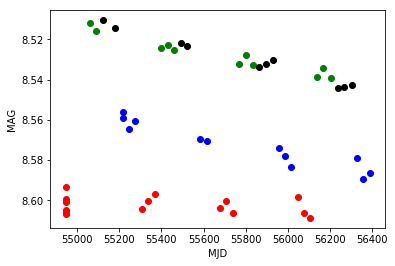

(281.06580062022897, 47.674570850003406, 'kplr2009114174833_ffi-cal.fits[15]')


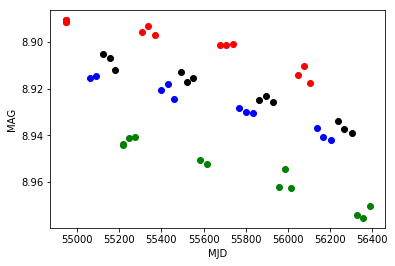

(289.86330415454705, 38.02818387052353, 'kplr2009114174833_ffi-cal.fits[29]')


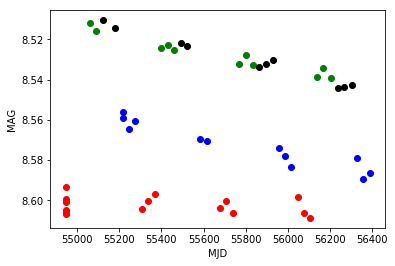

(281.0659413436924, 47.674820019383326, 'kplr2009114204835_ffi-cal.fits[15]')


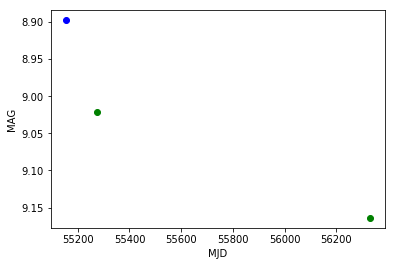

(292.5743879658267, 48.65116456063824, 'kplr2009322233047_ffi-cal.fits[25]')


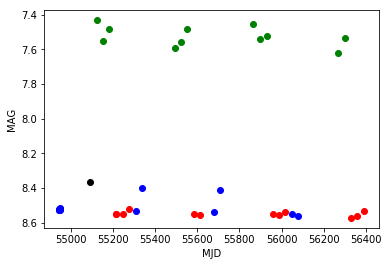

(293.2555181191914, 42.167597797237256, 'kplr2009322233047_ffi-cal.fits[39]')


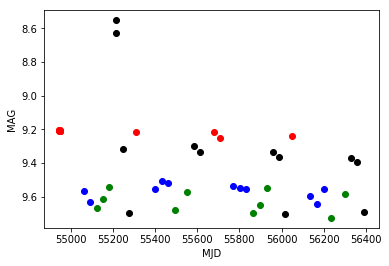

(284.4915861187469, 45.639227820339016, 'kplr2010019225502_ffi-cal.fits[28]')


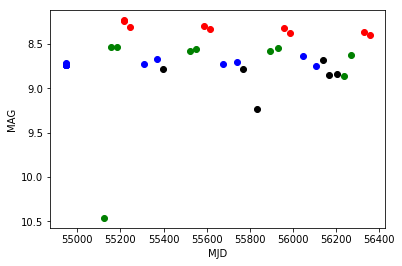

(288.44186318816713, 40.02411075963774, 'kplr2010019225502_ffi-cal.fits[65]')


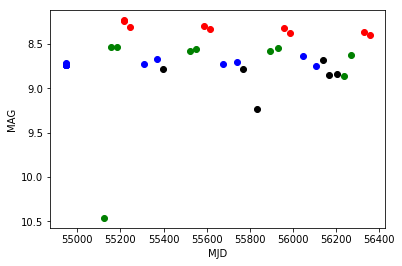

(288.44181487436686, 40.0241846061678, 'kplr2010020005046_ffi-cal.fits[65]')


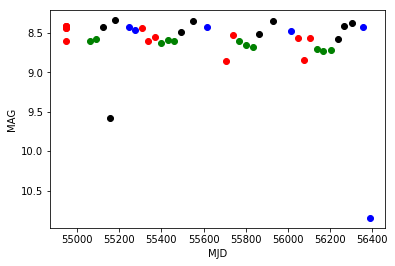

(282.03534530355205, 47.26822868719558, 'kplr2010111125026_ffi-cal.fits[15]')


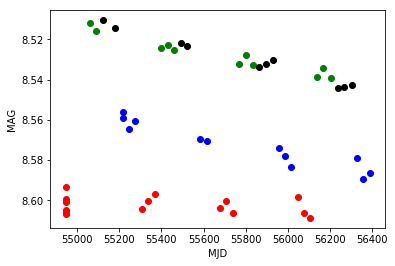

(281.0659413882968, 47.67459822763393, 'kplr2010140101631_ffi-cal.fits[15]')


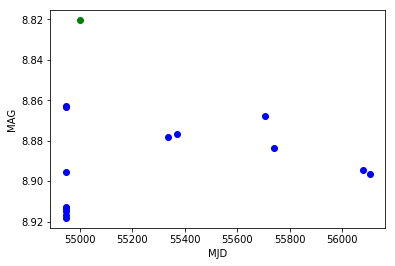

(291.8406505579973, 41.72720164556661, 'kplr2010140101631_ffi-cal.fits[45]')


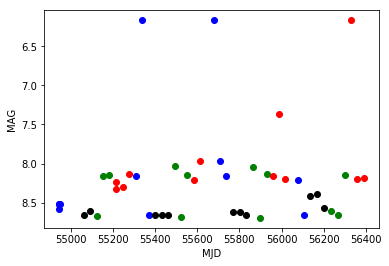

(285.0571639028919, 40.61492209666448, 'kplr2010234192745_ffi-cal.fits[34]')


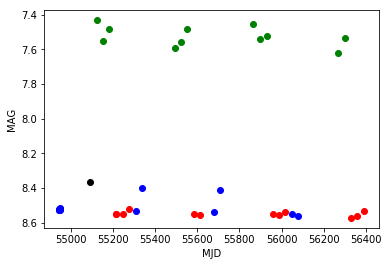

(293.2559333689719, 42.16739533280967, 'kplr2010326181728_ffi-cal.fits[39]')


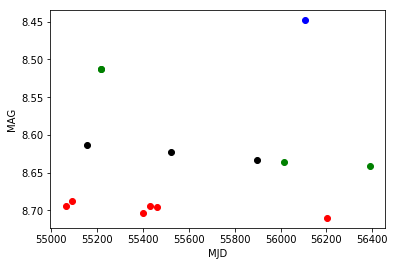

(285.91111034478854, 44.47348326142481, 'kplr2010326181728_ffi-cal.fits[66]')


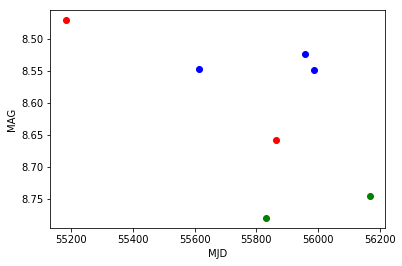

(285.3822757344309, 44.98637326566493, 'kplr2011053174401_ffi-cal.fits[26]')


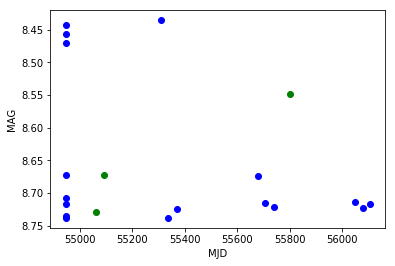

(295.30044838911095, 40.19813475404654, 'kplr2011177110110_ffi-cal.fits[50]')


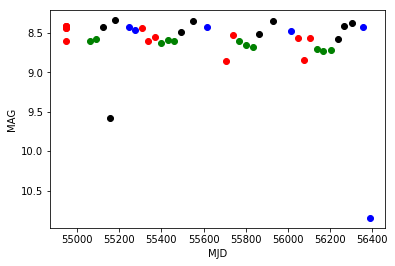

(282.0352651426848, 47.268911953801606, 'kplr2011240181752_ffi-cal.fits[75]')


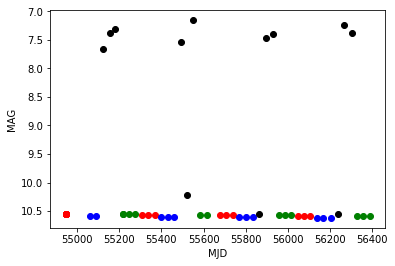

(295.04023677145346, 42.88009862622093, 'kplr2011334181008_ffi-cal.fits[17]')


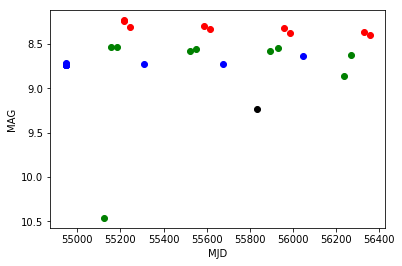

(288.44319323001105, 40.024516582336666, 'kplr2012121122500_ffi-cal.fits[25]')


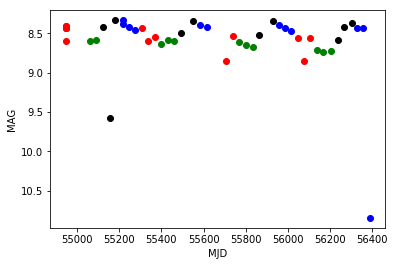

(282.0357171240712, 47.26918929870344, 'kplr2012151105138_ffi-cal.fits[15]')


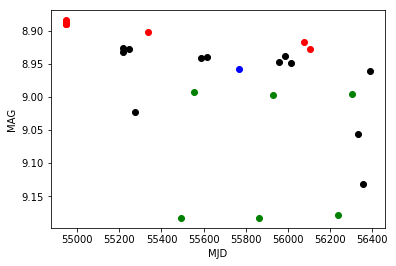

(289.65247405672727, 47.32778800607652, 'kplr2012151105138_ffi-cal.fits[37]')


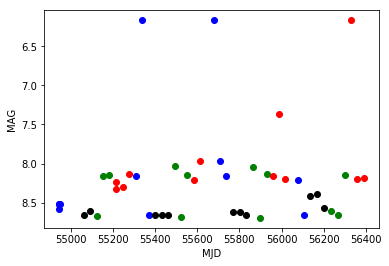

(285.05693607339543, 40.6146068424017, 'kplr2012242195726_ffi-cal.fits[34]')


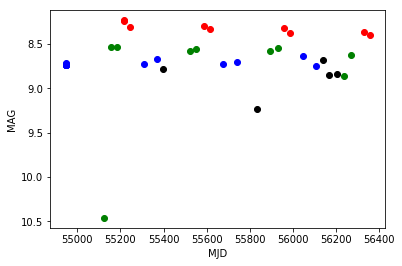

(288.4425853460137, 40.02334188034389, 'kplr2012310200152_ffi-cal.fits[57]')


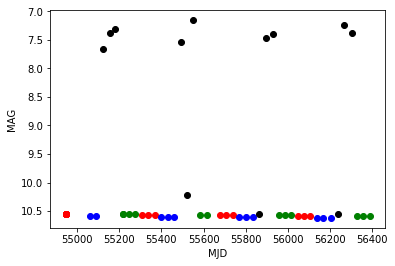

(295.0406644792216, 42.879860972498, 'kplr2012341215621_ffi-cal.fits[17]')


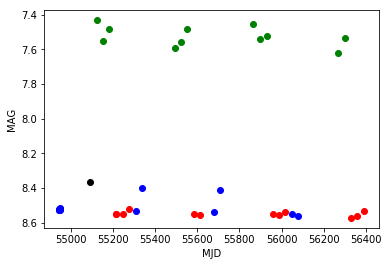

(293.25545320988607, 42.16653300167808, 'kplr2012341215621_ffi-cal.fits[39]')


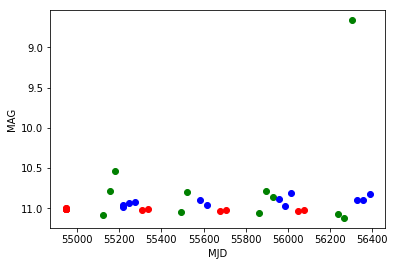

(291.5850787899832, 48.43674100940777, 'kplr2013011160902_ffi-cal.fits[27]')


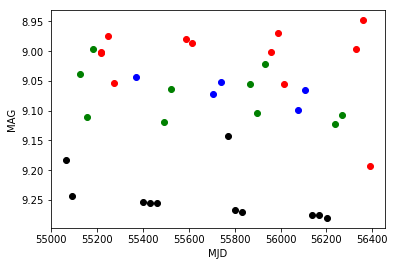

(281.5595290837081, 43.893302122615225, 'kplr2013065115251_ffi-cal.fits[29]')


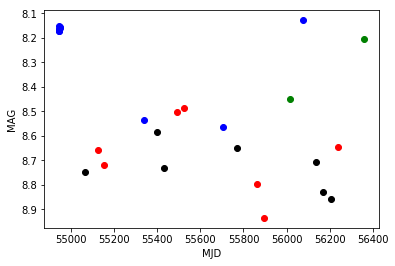

(293.62399242064873, 42.5367334023391, 'kplr2013065115251_ffi-cal.fits[62]')


In [24]:
origTab = ascii.read('/home/mj1e16/outTablesImproved/final/100sn.csv')
makeLightCurves(origTab)

In [ ]:
origTab = ascii.read('/home/mj1e16/outTablesImproved/final/magone.csv')
outputSmoll = makeLightCurves(origTab)

('kplr2009114174833_ffi-cal.fits[12]', '12')
('index 0', 1)
('kplr2009114174833_ffi-cal.fits[13]', '13')
('index 1', 1)
('kplr2009114174833_ffi-cal.fits[15]', '15')
('index 2', 1)
('kplr2009114174833_ffi-cal.fits[16]', '16')
('index 3', 1)
('kplr2009114174833_ffi-cal.fits[19]', '19')
('index 4', 1)
('kplr2009114174833_ffi-cal.fits[19]', '19')
('index 5', 1)
('kplr2009114174833_ffi-cal.fits[21]', '21')
('index 6', 1)
('kplr2009114174833_ffi-cal.fits[21]', '21')
('index 7', 1)
('kplr2009114174833_ffi-cal.fits[24]', '24')
('index 8', 1)
Redo file kplr2012088132324_ffi-cal.fits[8]
('kplr2009114174833_ffi-cal.fits[36]', '36')
Redo file kplr2013038133130_ffi-cal.fits[8]
Redo file kplr2010019225502_ffi-cal.fits[8]
Redo file kplr2013098115308_ffi-cal.fits[8]
Redo file kplr2010020005046_ffi-cal.fits[8]
Redo file kplr2010078174524_ffi-cal.fits[8]
Redo file kplr2011053174401_ffi-cal.fits[8]
Redo file kplr2011024134926_ffi-cal.fits[8]
Redo file kplr2013065115251_ffi-cal.fits[8]
Redo file kplr20120

In [33]:
print(output[0])

[[54945.72162632], [54945.72162632], [54945.72162632], [54945.72162632], [54945.72162632], [54945.72162632], [54945.72162632], [54945.72162632], [54945.72162632], [54945.72162632], [54945.72162632], [54945.72162632], [54945.72162632], [54945.72162632], [54945.72162632], [54945.72162632], [54945.72162632], [54945.72162632], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.84664962], [54945.99778262], [54945.99778262], [54945.99778262], [54945.99778262], [54945.99778262], [54945.99778262], [54945.99778262], [54945.99778262], [54945.99778262], [54945.99778262], [54945.99778262], [54945.99778262], [54945.99778262], [54945.99

('kplr2009114174833_ffi-cal.fits[12]', '12')
('index 0', 1)
('kplr2009114174833_ffi-cal.fits[13]', '13')
('index 1', 1)
('kplr2009114174833_ffi-cal.fits[15]', '15')
('index 2', 1)
('kplr2009114174833_ffi-cal.fits[16]', '16')
('index 3', 1)
('kplr2009114174833_ffi-cal.fits[19]', '19')
('index 4', 1)
('kplr2009114174833_ffi-cal.fits[19]', '19')
('index 5', 1)
('kplr2009114174833_ffi-cal.fits[21]', '21')
('index 6', 1)
('kplr2009114174833_ffi-cal.fits[21]', '21')
('index 7', 1)
('kplr2009114174833_ffi-cal.fits[24]', '24')
('index 8', 1)
Redo file kplr2012088132324_ffi-cal.fits[8]
('kplr2009114174833_ffi-cal.fits[36]', '36')
Redo file kplr2013038133130_ffi-cal.fits[8]
Redo file kplr2010019225502_ffi-cal.fits[8]
Redo file kplr2013098115308_ffi-cal.fits[8]
Redo file kplr2010020005046_ffi-cal.fits[8]
Redo file kplr2010078174524_ffi-cal.fits[8]
Redo file kplr2011053174401_ffi-cal.fits[8]
Redo file kplr2011024134926_ffi-cal.fits[8]
Redo file kplr2013065115251_ffi-cal.fits[8]
Redo file kplr20120

Redo file kplr2012341215621_ffi-cal.fits[6]
Redo file kplr2010296192119_ffi-cal.fits[6]
Redo file kplr2012310200152_ffi-cal.fits[6]
('kplr2009115002613_ffi-cal.fits[78]', '78')
Redo file kplr2012004204112_ffi-cal.fits[6]
Redo file kplr2010356020128_ffi-cal.fits[6]
Redo file kplr2010326181728_ffi-cal.fits[6]
('index 62', 1)
Redo file kplr2012121122500_ffi-cal.fits[7]
Redo file kplr2010111125026_ffi-cal.fits[7]
Redo file kplr2011177110110_ffi-cal.fits[7]
Redo file kplr2010174164113_ffi-cal.fits[7]
Redo file kplr2011116104002_ffi-cal.fits[7]
Redo file kplr2010140101631_ffi-cal.fits[7]
Redo file kplr2012179140901_ffi-cal.fits[7]
Redo file kplr2011145152723_ffi-cal.fits[7]
Redo file kplr2012151105138_ffi-cal.fits[7]
('kplr2009115002613_ffi-cal.fits[7]', '7')
('index 63', 1)
('kplr2009115053616_ffi-cal.fits[14]', '14')
('index 64', 1)
('kplr2009115053616_ffi-cal.fits[14]', '14')
('index 65', 1)
('kplr2009115053616_ffi-cal.fits[15]', '15')
('index 66', 1)
('kplr2009115053616_ffi-cal.fits[15]'

Redo file kplr2010078174524_ffi-cal.fits[8]
Redo file kplr2011053174401_ffi-cal.fits[8]
Redo file kplr2011024134926_ffi-cal.fits[8]
Redo file kplr2013065115251_ffi-cal.fits[8]
('kplr2009115131122_ffi-cal.fits[36]', '36')
Redo file kplr2012032101442_ffi-cal.fits[8]
Redo file kplr2010049182302_ffi-cal.fits[8]
Redo file kplr2012060123308_ffi-cal.fits[8]
('index 112', 1)
Redo file kplr2012088132324_ffi-cal.fits[8]
Redo file kplr2013038133130_ffi-cal.fits[8]
Redo file kplr2010019225502_ffi-cal.fits[8]
Redo file kplr2013098115308_ffi-cal.fits[8]
Redo file kplr2010020005046_ffi-cal.fits[8]
Redo file kplr2010078174524_ffi-cal.fits[8]
Redo file kplr2011053174401_ffi-cal.fits[8]
Redo file kplr2011024134926_ffi-cal.fits[8]
Redo file kplr2013065115251_ffi-cal.fits[8]
('kplr2009115131122_ffi-cal.fits[36]', '36')
Redo file kplr2012032101442_ffi-cal.fits[8]
Redo file kplr2010049182302_ffi-cal.fits[8]
Redo file kplr2012060123308_ffi-cal.fits[8]
('index 113', 1)
Redo file kplr2012088132324_ffi-cal.fits

kplr2010174164113_ffi-cal.fits[46]
kplr2009114174833_ffi-cal.fits[46]
kplr2011334181008_ffi-cal.fits[38]
kplr2009114204835_ffi-cal.fits[46]
kplr2009115080620_ffi-cal.fits[46]
kplr2012310200152_ffi-cal.fits[38]
kplr2012179140901_ffi-cal.fits[46]
kplr2009351005245_ffi-cal.fits[38]
kplr2010078174524_ffi-cal.fits[62]
kplr2009115002613_ffi-cal.fits[46]
kplr2009116035924_ffi-cal.fits[46]
kplr2012277203051_ffi-cal.fits[22]
kplr2009115173611_ffi-cal.fits[46]
kplr2010326181728_ffi-cal.fits[38]
kplr2013065115251_ffi-cal.fits[62]
kplr2009115053616_ffi-cal.fits[46]
kplr2009115131122_ffi-cal.fits[46]
('index 156', 18)
('kplr2009116035924_ffi-cal.fits[55]', '55')
('index 157', 1)
('kplr2009116035924_ffi-cal.fits[55]', '55')
('index 158', 1)
('kplr2009116035924_ffi-cal.fits[60]', '60')
('index 159', 1)
Redo file kplr2012121122500_ffi-cal.fits[6]
Redo file kplr2010111125026_ffi-cal.fits[6]
Redo file kplr2011177110110_ffi-cal.fits[6]
Redo file kplr2010174164113_ffi-cal.fits[6]
Redo file kplr20111161040

Redo file kplr2011116104002_ffi-cal.fits[8]
Redo file kplr2010140101631_ffi-cal.fits[8]
Redo file kplr2012179140901_ffi-cal.fits[8]
Redo file kplr2011145152723_ffi-cal.fits[8]
Redo file kplr2012151105138_ffi-cal.fits[8]
('index 183', 1)
('kplr2009260000800_ffi-cal.fits[54]', '54')
('index 184', 1)
('kplr2009260000800_ffi-cal.fits[56]', '56')
('index 185', 1)
('kplr2012121122500_ffi-cal.fits[17]', '17')
kplr2011240181752_ffi-cal.fits[57]
kplr2009322233047_ffi-cal.fits[65]
kplr2010111125026_ffi-cal.fits[17]
kplr2011177110110_ffi-cal.fits[17]
kplr2013011160902_ffi-cal.fits[65]
kplr2011271191331_ffi-cal.fits[57]
kplr2010174164113_ffi-cal.fits[17]
kplr2012088132324_ffi-cal.fits[25]
kplr2010265195356_ffi-cal.fits[57]
kplr2009114174833_ffi-cal.fits[17]
kplr2011303191211_ffi-cal.fits[65]
kplr2011334181008_ffi-cal.fits[65]
kplr2009260000800_ffi-cal.fits[57]
kplr2009114204835_ffi-cal.fits[17]
kplr2012341215621_ffi-cal.fits[65]
kplr2009115080620_ffi-cal.fits[17]
kplr2010296192119_ffi-cal.fits[65]

Redo file kplr2010174164113_ffi-cal.fits[8]
Redo file kplr2011116104002_ffi-cal.fits[8]
Redo file kplr2010140101631_ffi-cal.fits[8]
Redo file kplr2012179140901_ffi-cal.fits[8]
Redo file kplr2011145152723_ffi-cal.fits[8]
Redo file kplr2012151105138_ffi-cal.fits[8]
('index 223', 1)
('kplr2009322233047_ffi-cal.fits[81]', '81')
('index 224', 1)
('kplr2009322233047_ffi-cal.fits[82]', '82')
('index 225', 1)
('kplr2009322233047_ffi-cal.fits[83]', '83')
('index 226', 1)
('kplr2009322233047_ffi-cal.fits[83]', '83')
('index 227', 1)
('kplr2009322233047_ffi-cal.fits[84]', '84')
('index 228', 1)
('kplr2009351005245_ffi-cal.fits[18]', '18')
('index 229', 1)
('kplr2009351005245_ffi-cal.fits[22]', '22')
('index 230', 1)
('kplr2009351005245_ffi-cal.fits[30]', '30')
('index 231', 1)
('kplr2009351005245_ffi-cal.fits[31]', '31')
('index 232', 1)
('kplr2009351005245_ffi-cal.fits[46]', '46')
('index 233', 1)
('kplr2009351005245_ffi-cal.fits[48]', '48')
('index 234', 1)
Redo file kplr2012088132324_ffi-cal.f

('kplr2010020005046_ffi-cal.fits[10]', '10')
('index 272', 1)
('kplr2010020005046_ffi-cal.fits[10]', '10')
('index 273', 1)
('kplr2010020005046_ffi-cal.fits[20]', '20')
('index 274', 1)
('kplr2010020005046_ffi-cal.fits[23]', '23')
('index 275', 1)
('kplr2010020005046_ffi-cal.fits[23]', '23')
('index 276', 1)
('kplr2010020005046_ffi-cal.fits[23]', '23')
('index 277', 1)
('kplr2010020005046_ffi-cal.fits[27]', '27')
('index 278', 1)
('kplr2010020005046_ffi-cal.fits[30]', '30')
('index 279', 1)
('kplr2010020005046_ffi-cal.fits[32]', '32')
('index 280', 1)
('kplr2010020005046_ffi-cal.fits[3]', '3')
('index 281', 1)
('kplr2010020005046_ffi-cal.fits[48]', '48')
('index 282', 1)
Redo file kplr2012121122500_ffi-cal.fits[5]
Redo file kplr2010111125026_ffi-cal.fits[5]
Redo file kplr2011177110110_ffi-cal.fits[5]
Redo file kplr2010174164113_ffi-cal.fits[5]
Redo file kplr2011116104002_ffi-cal.fits[5]
Redo file kplr2010140101631_ffi-cal.fits[5]
('kplr2010020005046_ffi-cal.fits[49]', '49')
Redo file k

kplr2011208112727_ffi-cal.fits[81]
kplr2009231194831_ffi-cal.fits[81]
kplr2010078174524_ffi-cal.fits[1]
kplr2012211123923_ffi-cal.fits[81]
kplr2011053174401_ffi-cal.fits[1]
kplr2011145152723_ffi-cal.fits[53]
kplr2011024134926_ffi-cal.fits[1]
kplr2012151105138_ffi-cal.fits[53]
kplr2009115002613_ffi-cal.fits[53]
kplr2009116035924_ffi-cal.fits[53]
kplr2009292020429_ffi-cal.fits[29]
kplr2010203012215_ffi-cal.fits[81]
kplr2012004204112_ffi-cal.fits[29]
kplr2012277203051_ffi-cal.fits[81]
kplr2009115173611_ffi-cal.fits[53]
kplr2010356020128_ffi-cal.fits[29]
kplr2010326181728_ffi-cal.fits[29]
kplr2012242195726_ffi-cal.fits[81]
kplr2013065115251_ffi-cal.fits[1]
kplr2009115053616_ffi-cal.fits[53]
kplr2009115131122_ffi-cal.fits[53]
kplr2012032101442_ffi-cal.fits[1]
kplr2010049182302_ffi-cal.fits[1]
kplr2012060123308_ffi-cal.fits[1]
('index 329', 52)
('kplr2010111125026_ffi-cal.fits[56]', '56')
('index 330', 1)
('kplr2010111125026_ffi-cal.fits[59]', '59')
('index 331', 1)
('kplr2010111125026_ffi-c

Redo file kplr2012151105138_ffi-cal.fits[6]
('kplr2010203012215_ffi-cal.fits[34]', '34')
('index 378', 1)
Redo file kplr2012121122500_ffi-cal.fits[7]
Redo file kplr2010111125026_ffi-cal.fits[7]
Redo file kplr2011177110110_ffi-cal.fits[7]
Redo file kplr2010174164113_ffi-cal.fits[7]
Redo file kplr2011116104002_ffi-cal.fits[7]
Redo file kplr2010140101631_ffi-cal.fits[7]
Redo file kplr2012179140901_ffi-cal.fits[7]
Redo file kplr2011145152723_ffi-cal.fits[7]
Redo file kplr2012151105138_ffi-cal.fits[7]
('kplr2010203012215_ffi-cal.fits[35]', '35')
('index 379', 1)
Redo file kplr2012121122500_ffi-cal.fits[8]
Redo file kplr2010111125026_ffi-cal.fits[8]
Redo file kplr2011177110110_ffi-cal.fits[8]
Redo file kplr2010174164113_ffi-cal.fits[8]
Redo file kplr2011116104002_ffi-cal.fits[8]
Redo file kplr2010140101631_ffi-cal.fits[8]
Redo file kplr2012179140901_ffi-cal.fits[8]
Redo file kplr2011145152723_ffi-cal.fits[8]
Redo file kplr2012151105138_ffi-cal.fits[8]
('kplr2010203012215_ffi-cal.fits[36]', '

Redo file kplr2012179140901_ffi-cal.fits[8]
Redo file kplr2011145152723_ffi-cal.fits[8]
Redo file kplr2012151105138_ffi-cal.fits[8]
('index 422', 1)
('kplr2010265195356_ffi-cal.fits[53]', '53')
('index 423', 1)
('kplr2010265195356_ffi-cal.fits[53]', '53')
('index 424', 1)
('kplr2010265195356_ffi-cal.fits[54]', '54')
('index 425', 1)
('kplr2010265195356_ffi-cal.fits[55]', '55')
('index 426', 1)
('kplr2010265195356_ffi-cal.fits[58]', '58')
('index 427', 1)
('kplr2010265195356_ffi-cal.fits[64]', '64')
('index 428', 1)
('kplr2010265195356_ffi-cal.fits[74]', '74')
('index 429', 1)
('kplr2010265195356_ffi-cal.fits[74]', '74')
('index 430', 1)
('kplr2010265195356_ffi-cal.fits[74]', '74')
('index 431', 1)
('kplr2010265195356_ffi-cal.fits[75]', '75')
('index 432', 1)
('kplr2010265195356_ffi-cal.fits[76]', '76')
('index 433', 1)
Redo file kplr2012088132324_ffi-cal.fits[5]
('kplr2010265195356_ffi-cal.fits[77]', '77')
Redo file kplr2013038133130_ffi-cal.fits[5]
Redo file kplr2010019225502_ffi-cal.

Redo file kplr2011116104002_ffi-cal.fits[5]
Redo file kplr2010140101631_ffi-cal.fits[5]
Redo file kplr2012179140901_ffi-cal.fits[5]
Redo file kplr2011145152723_ffi-cal.fits[5]
Redo file kplr2012151105138_ffi-cal.fits[5]
('kplr2010326181728_ffi-cal.fits[77]', '77')
('index 466', 1)
('kplr2010326181728_ffi-cal.fits[84]', '84')
('index 467', 1)
('kplr2010326181728_ffi-cal.fits[84]', '84')
('index 468', 1)
('kplr2010356020128_ffi-cal.fits[23]', '23')
('index 469', 1)
('kplr2010356020128_ffi-cal.fits[29]', '29')
('index 470', 1)
('kplr2010356020128_ffi-cal.fits[29]', '29')
('index 471', 1)
('kplr2010356020128_ffi-cal.fits[29]', '29')
('index 472', 1)
('kplr2010356020128_ffi-cal.fits[41]', '41')
('index 473', 1)
Redo file kplr2012088132324_ffi-cal.fits[6]
Redo file kplr2013038133130_ffi-cal.fits[6]
Redo file kplr2010019225502_ffi-cal.fits[6]
Redo file kplr2013098115308_ffi-cal.fits[6]
Redo file kplr2010020005046_ffi-cal.fits[6]
Redo file kplr2010078174524_ffi-cal.fits[6]
Redo file kplr201105

Redo file kplr2010078174524_ffi-cal.fits[8]
Redo file kplr2011053174401_ffi-cal.fits[8]
Redo file kplr2011024134926_ffi-cal.fits[8]
Redo file kplr2013065115251_ffi-cal.fits[8]
Redo file kplr2012032101442_ffi-cal.fits[8]
Redo file kplr2010049182302_ffi-cal.fits[8]
Redo file kplr2012060123308_ffi-cal.fits[8]
('index 525', 1)
('kplr2011116104002_ffi-cal.fits[3]', '3')
('index 526', 1)
('kplr2011116104002_ffi-cal.fits[3]', '3')
('index 527', 1)
('kplr2011116104002_ffi-cal.fits[44]', '44')
('index 528', 1)
('kplr2011116104002_ffi-cal.fits[4]', '4')
('index 529', 1)
('kplr2011116104002_ffi-cal.fits[55]', '55')
('index 530', 1)
('kplr2011116104002_ffi-cal.fits[57]', '57')
('index 531', 1)
('kplr2011116104002_ffi-cal.fits[58]', '58')
('index 532', 1)
('kplr2011116104002_ffi-cal.fits[59]', '59')
('index 533', 1)
('kplr2012121122500_ffi-cal.fits[71]', '71')
kplr2009322233047_ffi-cal.fits[15]
kplr2010111125026_ffi-cal.fits[71]
kplr2013011160902_ffi-cal.fits[15]
kplr2011271191331_ffi-cal.fits[11]


Redo file kplr2010078174524_ffi-cal.fits[6]
Redo file kplr2011053174401_ffi-cal.fits[6]
Redo file kplr2011024134926_ffi-cal.fits[6]
Redo file kplr2013065115251_ffi-cal.fits[6]
Redo file kplr2012032101442_ffi-cal.fits[6]
Redo file kplr2010049182302_ffi-cal.fits[6]
Redo file kplr2012060123308_ffi-cal.fits[6]
('index 578', 1)
Redo file kplr2012088132324_ffi-cal.fits[7]
Redo file kplr2013038133130_ffi-cal.fits[7]
Redo file kplr2010019225502_ffi-cal.fits[7]
Redo file kplr2013098115308_ffi-cal.fits[7]
Redo file kplr2010020005046_ffi-cal.fits[7]
('kplr2011208112727_ffi-cal.fits[79]', '79')
Redo file kplr2010078174524_ffi-cal.fits[7]
Redo file kplr2011053174401_ffi-cal.fits[7]
Redo file kplr2011024134926_ffi-cal.fits[7]
Redo file kplr2013065115251_ffi-cal.fits[7]
Redo file kplr2012032101442_ffi-cal.fits[7]
Redo file kplr2010049182302_ffi-cal.fits[7]
Redo file kplr2012060123308_ffi-cal.fits[7]
('index 579', 1)
Redo file kplr2012088132324_ffi-cal.fits[7]
Redo file kplr2013038133130_ffi-cal.fits[

Redo file kplr2010078174524_ffi-cal.fits[5]
Redo file kplr2011053174401_ffi-cal.fits[5]
Redo file kplr2011024134926_ffi-cal.fits[5]
Redo file kplr2013065115251_ffi-cal.fits[5]
Redo file kplr2012032101442_ffi-cal.fits[5]
Redo file kplr2010049182302_ffi-cal.fits[5]
Redo file kplr2012060123308_ffi-cal.fits[5]
('index 615', 1)
('kplr2011271191331_ffi-cal.fits[80]', '80')
Redo file kplr2012088132324_ffi-cal.fits[8]
Redo file kplr2013038133130_ffi-cal.fits[8]
Redo file kplr2010019225502_ffi-cal.fits[8]
Redo file kplr2013098115308_ffi-cal.fits[8]
Redo file kplr2010020005046_ffi-cal.fits[8]
Redo file kplr2010078174524_ffi-cal.fits[8]
Redo file kplr2011053174401_ffi-cal.fits[8]
Redo file kplr2011024134926_ffi-cal.fits[8]
Redo file kplr2013065115251_ffi-cal.fits[8]
Redo file kplr2012032101442_ffi-cal.fits[8]
Redo file kplr2010049182302_ffi-cal.fits[8]
Redo file kplr2012060123308_ffi-cal.fits[8]
('index 616', 1)
('kplr2011271191331_ffi-cal.fits[82]', '82')
('index 617', 1)
('kplr2011303191211_ffi

Redo file kplr2011145152723_ffi-cal.fits[6]
Redo file kplr2012151105138_ffi-cal.fits[6]
('kplr2012004204112_ffi-cal.fits[78]', '78')
('index 665', 1)
Redo file kplr2012121122500_ffi-cal.fits[7]
Redo file kplr2010111125026_ffi-cal.fits[7]
Redo file kplr2011177110110_ffi-cal.fits[7]
Redo file kplr2010174164113_ffi-cal.fits[7]
Redo file kplr2011116104002_ffi-cal.fits[7]
Redo file kplr2010140101631_ffi-cal.fits[7]
Redo file kplr2012179140901_ffi-cal.fits[7]
Redo file kplr2011145152723_ffi-cal.fits[7]
Redo file kplr2012151105138_ffi-cal.fits[7]
('kplr2012004204112_ffi-cal.fits[79]', '79')
('index 666', 1)
('kplr2012032101442_ffi-cal.fits[10]', '10')
('index 667', 1)
('kplr2012032101442_ffi-cal.fits[11]', '11')
('index 668', 1)
('kplr2012032101442_ffi-cal.fits[14]', '14')
('index 669', 1)
('kplr2012032101442_ffi-cal.fits[17]', '17')
('index 670', 1)
('kplr2012032101442_ffi-cal.fits[28]', '28')
('index 671', 1)
('kplr2012032101442_ffi-cal.fits[31]', '31')
('index 672', 1)
('kplr2012032101442_

Redo file kplr2012088132324_ffi-cal.fits[7]
Redo file kplr2013038133130_ffi-cal.fits[7]
Redo file kplr2010019225502_ffi-cal.fits[7]
Redo file kplr2013098115308_ffi-cal.fits[7]
Redo file kplr2010020005046_ffi-cal.fits[7]
Redo file kplr2010078174524_ffi-cal.fits[7]
Redo file kplr2011053174401_ffi-cal.fits[7]
Redo file kplr2011024134926_ffi-cal.fits[7]
('kplr2012151105138_ffi-cal.fits[35]', '35')
Redo file kplr2013065115251_ffi-cal.fits[7]
Redo file kplr2012032101442_ffi-cal.fits[7]
Redo file kplr2010049182302_ffi-cal.fits[7]
Redo file kplr2012060123308_ffi-cal.fits[7]
('index 730', 1)
Redo file kplr2012088132324_ffi-cal.fits[8]
Redo file kplr2013038133130_ffi-cal.fits[8]
Redo file kplr2010019225502_ffi-cal.fits[8]
Redo file kplr2013098115308_ffi-cal.fits[8]
Redo file kplr2010020005046_ffi-cal.fits[8]
Redo file kplr2010078174524_ffi-cal.fits[8]
Redo file kplr2011053174401_ffi-cal.fits[8]
Redo file kplr2011024134926_ffi-cal.fits[8]
('kplr2012151105138_ffi-cal.fits[36]', '36')
Redo file kpl

Redo file kplr2012032101442_ffi-cal.fits[5]
Redo file kplr2010049182302_ffi-cal.fits[5]
Redo file kplr2012060123308_ffi-cal.fits[5]
('index 761', 1)
Redo file kplr2012088132324_ffi-cal.fits[8]
Redo file kplr2013038133130_ffi-cal.fits[8]
Redo file kplr2010019225502_ffi-cal.fits[8]
Redo file kplr2013098115308_ffi-cal.fits[8]
Redo file kplr2010020005046_ffi-cal.fits[8]
Redo file kplr2010078174524_ffi-cal.fits[8]
('kplr2012211123923_ffi-cal.fits[80]', '80')
Redo file kplr2011053174401_ffi-cal.fits[8]
Redo file kplr2011024134926_ffi-cal.fits[8]
Redo file kplr2013065115251_ffi-cal.fits[8]
Redo file kplr2012032101442_ffi-cal.fits[8]
Redo file kplr2010049182302_ffi-cal.fits[8]
Redo file kplr2012060123308_ffi-cal.fits[8]
('index 762', 1)
('kplr2012211123923_ffi-cal.fits[83]', '83')
('index 763', 1)
Redo file kplr2012121122500_ffi-cal.fits[8]
Redo file kplr2010111125026_ffi-cal.fits[8]
Redo file kplr2011177110110_ffi-cal.fits[8]
Redo file kplr2010174164113_ffi-cal.fits[8]
Redo file kplr201111610

kplr2013065115251_ffi-cal.fits[62]
kplr2009115053616_ffi-cal.fits[46]
kplr2009115131122_ffi-cal.fits[46]
('index 784', 17)
Redo file kplr2012088132324_ffi-cal.fits[7]
Redo file kplr2013038133130_ffi-cal.fits[7]
Redo file kplr2010019225502_ffi-cal.fits[7]
('kplr2012310200152_ffi-cal.fits[51]', '51')
Redo file kplr2013098115308_ffi-cal.fits[7]
Redo file kplr2010020005046_ffi-cal.fits[7]
Redo file kplr2010078174524_ffi-cal.fits[7]
Redo file kplr2011053174401_ffi-cal.fits[7]
Redo file kplr2011024134926_ffi-cal.fits[7]
Redo file kplr2013065115251_ffi-cal.fits[7]
Redo file kplr2012032101442_ffi-cal.fits[7]
Redo file kplr2010049182302_ffi-cal.fits[7]
Redo file kplr2012060123308_ffi-cal.fits[7]
('index 785', 1)
Redo file kplr2012088132324_ffi-cal.fits[8]
Redo file kplr2013038133130_ffi-cal.fits[8]
Redo file kplr2010019225502_ffi-cal.fits[8]
('kplr2012310200152_ffi-cal.fits[52]', '52')
Redo file kplr2013098115308_ffi-cal.fits[8]
Redo file kplr2010020005046_ffi-cal.fits[8]
Redo file kplr20100781

Redo file kplr2012179140901_ffi-cal.fits[6]
Redo file kplr2011145152723_ffi-cal.fits[6]
Redo file kplr2012151105138_ffi-cal.fits[6]
('index 830', 1)
('kplr2013065115251_ffi-cal.fits[10]', '10')
('index 831', 1)
('kplr2013065115251_ffi-cal.fits[11]', '11')
('index 832', 1)
('kplr2013065115251_ffi-cal.fits[19]', '19')
('index 833', 1)
('kplr2013065115251_ffi-cal.fits[21]', '21')
('index 834', 1)
('kplr2013065115251_ffi-cal.fits[25]', '25')
('index 835', 1)
('kplr2013065115251_ffi-cal.fits[27]', '27')
('index 836', 1)
('kplr2013065115251_ffi-cal.fits[30]', '30')
('index 837', 1)
('kplr2013065115251_ffi-cal.fits[3]', '3')
('index 838', 1)
('kplr2013065115251_ffi-cal.fits[42]', '42')
('index 839', 1)
Redo file kplr2012121122500_ffi-cal.fits[6]
Redo file kplr2010111125026_ffi-cal.fits[6]
Redo file kplr2011177110110_ffi-cal.fits[6]
Redo file kplr2010174164113_ffi-cal.fits[6]
Redo file kplr2011116104002_ffi-cal.fits[6]
Redo file kplr2010140101631_ffi-cal.fits[6]
Redo file kplr2012179140901_ffi

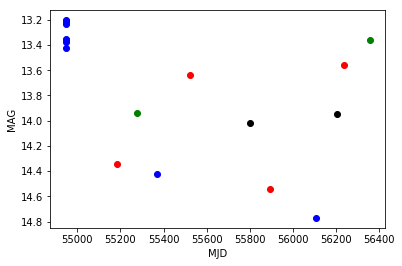

(292.2352304264401, 43.0936891516194, 'kplr2009115080620_ffi-cal.fits[46]')


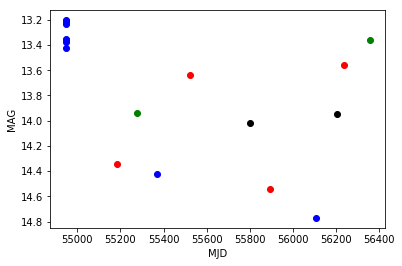

(292.23523049244886, 43.0936897017523, 'kplr2009115131122_ffi-cal.fits[46]')


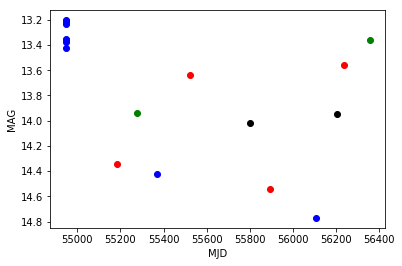

(292.2352301034367, 43.09368848492147, 'kplr2009115173611_ffi-cal.fits[46]')


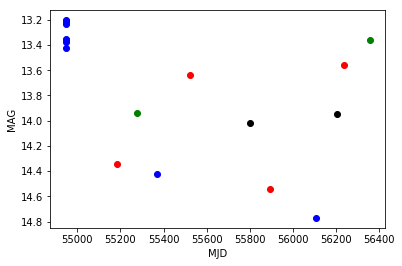

(292.23522908953754, 43.09369218659433, 'kplr2009116035924_ffi-cal.fits[46]')


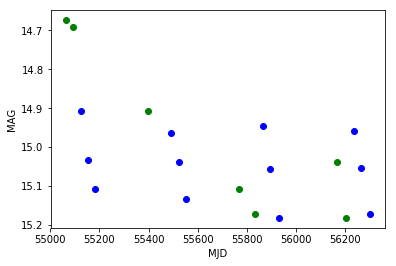

(293.13394414387665, 39.29012797973521, 'kplr2009231194831_ffi-cal.fits[5]')


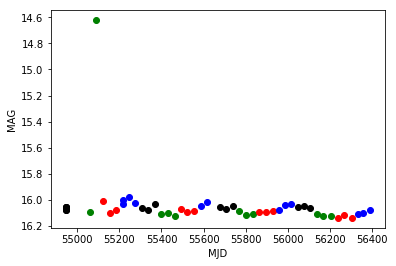

(285.7272286846728, 46.42772649282039, 'kplr2009260000800_ffi-cal.fits[57]')


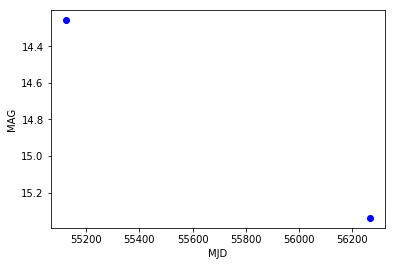

(288.1480409780076, 50.575179784264684, 'kplr2009292020429_ffi-cal.fits[31]')


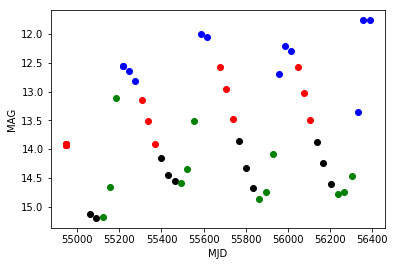

(284.20487551844514, 47.95321832161631, 'kplr2009351005245_ffi-cal.fits[69]')


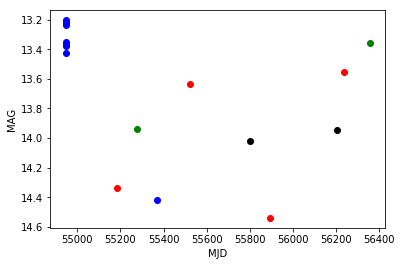

(292.23520576067165, 43.0937589591203, 'kplr2010078174524_ffi-cal.fits[62]')


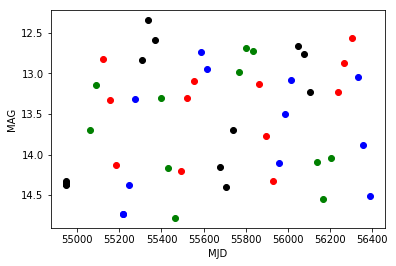

(291.4359254705428, 51.15885929182814, 'kplr2010111125026_ffi-cal.fits[53]')


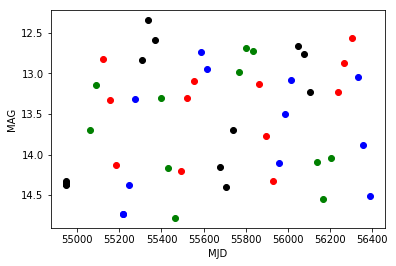

(291.43593325935973, 51.1588728232676, 'kplr2010140101631_ffi-cal.fits[53]')


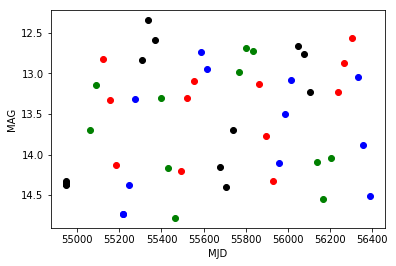

(291.43594106211066, 51.158905434676505, 'kplr2010174164113_ffi-cal.fits[53]')


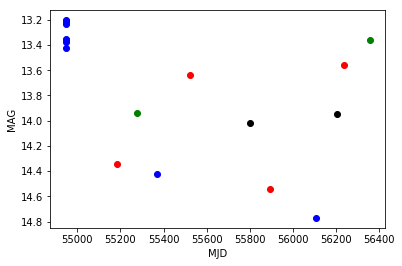

(292.23525590715076, 43.09376975642477, 'kplr2010326181728_ffi-cal.fits[38]')


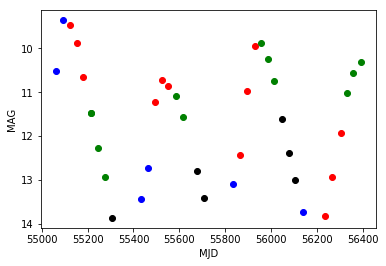

(298.33375917137886, 40.97142800044138, 'kplr2011116104002_ffi-cal.fits[71]')


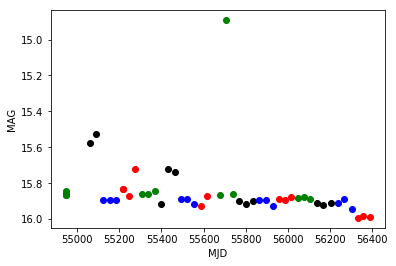

(294.6668925303648, 50.45855027469197, 'kplr2011145152723_ffi-cal.fits[74]')


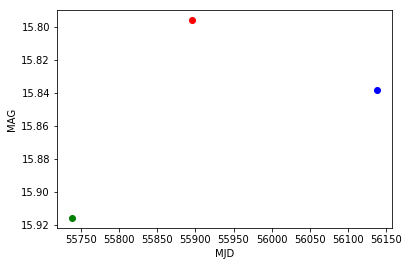

(292.20832134632974, 46.464068835819646, 'kplr2011177110110_ffi-cal.fits[62]')


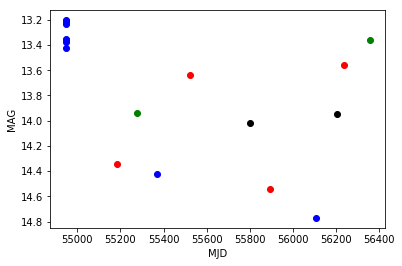

(292.23525867991003, 43.09377632603181, 'kplr2011240181752_ffi-cal.fits[22]')


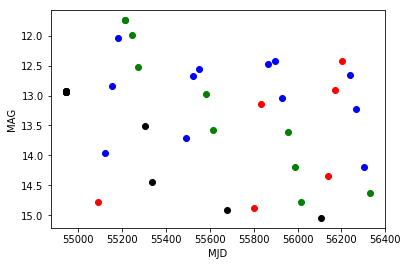

(292.3813052478641, 37.71123531004457, 'kplr2011271191331_ffi-cal.fits[3]')


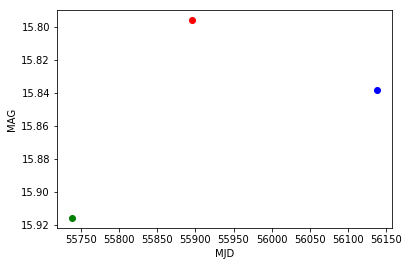

(292.20836218926235, 46.46419760319968, 'kplr2011334181008_ffi-cal.fits[22]')


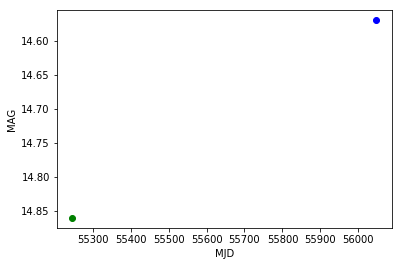

(288.4934079182069, 40.73577466652988, 'kplr2012121122500_ffi-cal.fits[25]')


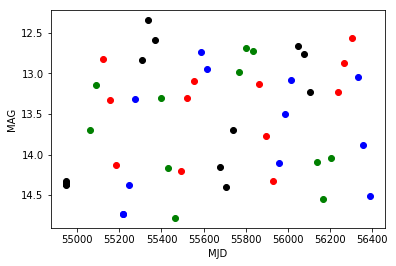

(291.43593232666944, 51.15887740349186, 'kplr2012121122500_ffi-cal.fits[53]')


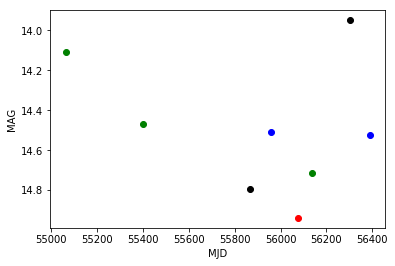

(281.16305305702406, 43.37459426241148, 'kplr2012151105138_ffi-cal.fits[4]')


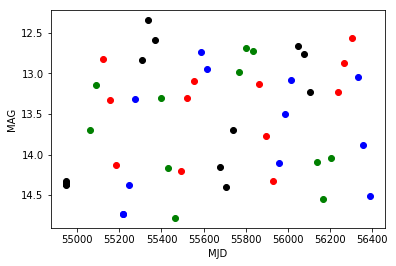

(291.4359309585661, 51.158901149659066, 'kplr2012151105138_ffi-cal.fits[53]')


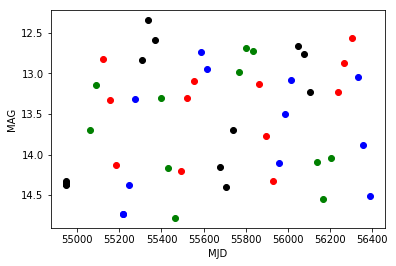

(291.43593409943276, 51.15892321087754, 'kplr2012179140901_ffi-cal.fits[53]')


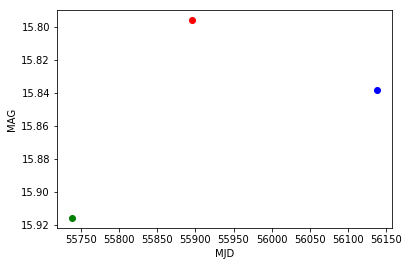

(292.2084021086923, 46.4642218707108, 'kplr2012211123923_ffi-cal.fits[46]')


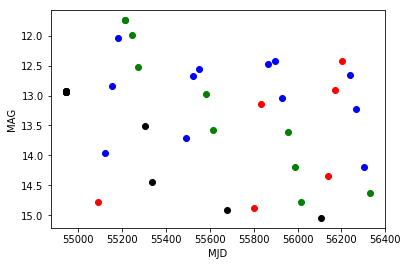

(292.3812911872557, 37.7111963697075, 'kplr2012242195726_ffi-cal.fits[3]')


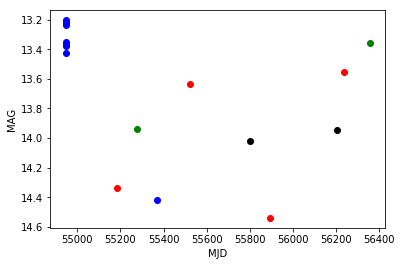

(292.23523419475157, 43.09379951828043, 'kplr2012277203051_ffi-cal.fits[22]')


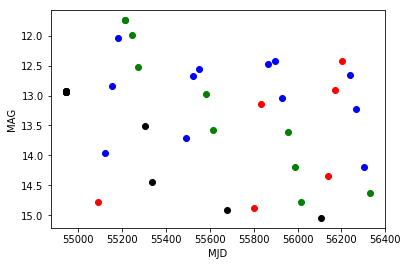

(292.38128035854936, 37.71125550421679, 'kplr2012277203051_ffi-cal.fits[3]')


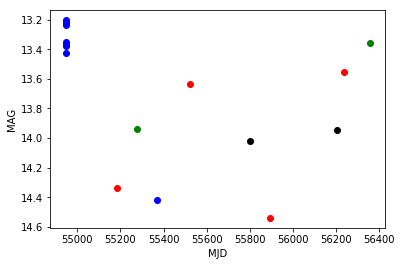

(292.23521430015495, 43.09380968431812, 'kplr2012310200152_ffi-cal.fits[38]')


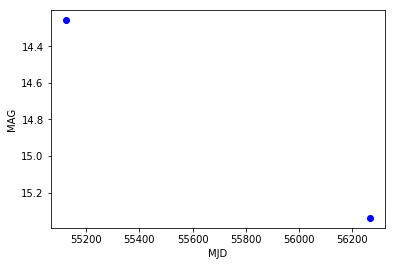

(288.14798518324847, 50.57520062753317, 'kplr2012341215621_ffi-cal.fits[31]')


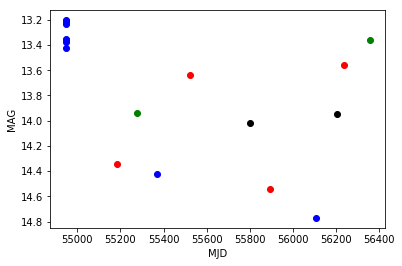

(292.2352209010263, 43.09376755458721, 'kplr2013065115251_ffi-cal.fits[62]')


In [27]:
makeLightCurves(origTab)

In [11]:
#origTab = ascii.read('/home/mj1e16/outTablesImproved/matchSNabove10.csv')

In [11]:
origTab = ascii.read('/home/mj1e16/outTablesImproved/match1mag.csv')

In [14]:
origTab = ascii.read('/home/mj1e16/outTablesImproved/final/100sn.csv')

In [15]:
origTab['OBJECT INDEX'] = range(len(origTab))

In [16]:
allTabs = []
imNames = []
mag = []
#date = []
imageReDo = []
fullExt = []
otherfullExt = []
for im in range(len(origTab)):
    ra = origTab['RA'][im]
    dec =origTab['DEC'][im]
    image = origTab['IMAGE_NAME'][im]
    indiext = getIndiExt(image,imagelist,extensionOrders)[0]
    nonindiext = getIndiExt(image,imagelist,extensionOrders)[1]
    allNames = getAllccds(imagelist,indiext,extensionOrders)
    testmatch = []
    magone = []
    imNameOne = []
    extensions = []
    for x in range(len(allNames)):
        loc1 = allNames[x].find(imageDirectory)+len(imageDirectory)
        imNameOnly = allNames[x][loc1:]
        loc2 = imNameOnly.find('[')+1
        loc3 = imNameOnly.find(']')
        imextOnly = imNameOnly[loc2:loc3]
        oneimTab = ascii.read('/home/mj1e16/outTablesImproved/imagecsv/'+imNameOnly+'.csv')
        oneimTab['OBJECT INDEX'] = range(len(oneimTab))
        if len(testmatch) == 0:
            try:
                testmatch = findMatchesNoCondition(oneimTab,ra,dec)
                if len(testmatch) != 0:
                    onemag = testmatch['MAG_BEST'][0]
                    magone.append(onemag)
                    imNameOne.append(imNameOnly)
                    extensions.append(imextOnly)
                    #extensionsOther.append(indiext)
                    print(imNameOnly,imextOnly)
    #                 mag.append(testmatch['MAG_BEST'][0])
                    #imNames.append(imNameOnly)
            except:
                imageReDo.append(imNameOnly)
                print('Redo file '+imNameOnly)
        else:
            try:
                oneim = findMatchesNoCondition(oneimTab,ra,dec)

            except:
                imageReDo.append(imNameOnly)
                print('Redo file '+imNameOnly)
            if len(oneim) != 0:
                onemag = oneim['MAG_BEST'][0]
                magone.append(onemag)
                imNameOne.append(imNameOnly)
                extensions.append(imextOnly)
                #extensionsOther.append(indiext)
                print(imNameOnly)
                #print(testmatch['IMAGE_NAME'],oneim['IMAGE_NAME'])
                testmatch = vstack([testmatch,oneim])
                
        
    fullExt.append(extensions) 
    #otherfullExt.append(extensionsOther)
    imNames.append(imNameOne)
    mag.append(magone)
    
    #allTabs.append(testmatch)
    print('index {}'.format(im),len(testmatch))

('kplr2012121122500_ffi-cal.fits[15]', '15')
kplr2011240181752_ffi-cal.fits[75]
kplr2010111125026_ffi-cal.fits[15]
kplr2011177110110_ffi-cal.fits[15]
kplr2013011160902_ffi-cal.fits[71]
kplr2011271191331_ffi-cal.fits[75]
kplr2010174164113_ffi-cal.fits[15]
kplr2012088132324_ffi-cal.fits[11]
kplr2010265195356_ffi-cal.fits[75]
kplr2009114174833_ffi-cal.fits[15]
kplr2011303191211_ffi-cal.fits[71]
kplr2011334181008_ffi-cal.fits[71]
kplr2009260000800_ffi-cal.fits[75]
kplr2009114204835_ffi-cal.fits[15]
kplr2012341215621_ffi-cal.fits[71]
kplr2009115080620_ffi-cal.fits[15]
kplr2010296192119_ffi-cal.fits[71]
kplr2013038133130_ffi-cal.fits[11]
kplr2011116104002_ffi-cal.fits[15]
kplr2010140101631_ffi-cal.fits[15]
kplr2010019225502_ffi-cal.fits[11]
kplr2012310200152_ffi-cal.fits[71]
kplr2013098115308_ffi-cal.fits[11]
kplr2010020005046_ffi-cal.fits[11]
kplr2010234192745_ffi-cal.fits[75]
kplr2012179140901_ffi-cal.fits[15]
kplr2009351005245_ffi-cal.fits[71]
kplr2011208112727_ffi-cal.fits[75]
kplr200923

kplr2012242195726_ffi-cal.fits[60]
kplr2013065115251_ffi-cal.fits[28]
kplr2009115053616_ffi-cal.fits[20]
kplr2009115131122_ffi-cal.fits[20]
kplr2012032101442_ffi-cal.fits[28]
kplr2010049182302_ffi-cal.fits[28]
kplr2012060123308_ffi-cal.fits[28]
('index 5', 45)
('kplr2012121122500_ffi-cal.fits[25]', '25')
kplr2009322233047_ffi-cal.fits[57]
kplr2010111125026_ffi-cal.fits[25]
kplr2011177110110_ffi-cal.fits[25]
kplr2011271191331_ffi-cal.fits[17]
kplr2010174164113_ffi-cal.fits[25]
kplr2009114174833_ffi-cal.fits[25]
kplr2011334181008_ffi-cal.fits[57]
kplr2009114204835_ffi-cal.fits[25]
kplr2012341215621_ffi-cal.fits[57]
kplr2009115080620_ffi-cal.fits[25]
kplr2013038133130_ffi-cal.fits[65]
kplr2011116104002_ffi-cal.fits[25]
kplr2010019225502_ffi-cal.fits[65]
kplr2012310200152_ffi-cal.fits[57]
kplr2010020005046_ffi-cal.fits[65]
kplr2012179140901_ffi-cal.fits[25]
kplr2009351005245_ffi-cal.fits[57]
kplr2011208112727_ffi-cal.fits[17]
kplr2012211123923_ffi-cal.fits[17]
kplr2011053174401_ffi-cal.fit

kplr2011024134926_ffi-cal.fits[50]
Redo file kplr2012151105138_ffi-cal.fits[6]
kplr2012151105138_ffi-cal.fits[6]
kplr2009115002613_ffi-cal.fits[6]
kplr2009116035924_ffi-cal.fits[6]
kplr2009292020429_ffi-cal.fits[78]
kplr2010203012215_ffi-cal.fits[34]
kplr2012004204112_ffi-cal.fits[78]
kplr2012277203051_ffi-cal.fits[34]
kplr2010356020128_ffi-cal.fits[78]
kplr2010326181728_ffi-cal.fits[78]
kplr2012242195726_ffi-cal.fits[34]
kplr2013065115251_ffi-cal.fits[50]
kplr2012032101442_ffi-cal.fits[50]
kplr2010049182302_ffi-cal.fits[50]
kplr2012060123308_ffi-cal.fits[50]
('index 11', 47)
('kplr2012121122500_ffi-cal.fits[47]', '47')
kplr2009322233047_ffi-cal.fits[39]
kplr2010111125026_ffi-cal.fits[47]
kplr2013011160902_ffi-cal.fits[39]
kplr2012088132324_ffi-cal.fits[63]
kplr2009114174833_ffi-cal.fits[47]
kplr2011303191211_ffi-cal.fits[39]
kplr2011334181008_ffi-cal.fits[39]
kplr2009260000800_ffi-cal.fits[23]
kplr2009114204835_ffi-cal.fits[47]
kplr2012341215621_ffi-cal.fits[39]
kplr2009115080620_ffi-

kplr2010049182302_ffi-cal.fits[65]
kplr2012060123308_ffi-cal.fits[65]
('index 18', 30)
('kplr2012121122500_ffi-cal.fits[15]', '15')
kplr2011240181752_ffi-cal.fits[75]
kplr2009322233047_ffi-cal.fits[71]
kplr2010111125026_ffi-cal.fits[15]
kplr2011177110110_ffi-cal.fits[15]
kplr2013011160902_ffi-cal.fits[71]
kplr2011271191331_ffi-cal.fits[75]
kplr2010174164113_ffi-cal.fits[15]
kplr2012088132324_ffi-cal.fits[11]
kplr2010265195356_ffi-cal.fits[75]
kplr2009114174833_ffi-cal.fits[15]
kplr2011303191211_ffi-cal.fits[71]
kplr2009260000800_ffi-cal.fits[75]
kplr2009114204835_ffi-cal.fits[15]
kplr2012341215621_ffi-cal.fits[71]
kplr2009115080620_ffi-cal.fits[15]
kplr2010296192119_ffi-cal.fits[71]
kplr2013038133130_ffi-cal.fits[11]
kplr2010140101631_ffi-cal.fits[15]
kplr2010019225502_ffi-cal.fits[11]
kplr2012310200152_ffi-cal.fits[71]
kplr2013098115308_ffi-cal.fits[11]
kplr2010020005046_ffi-cal.fits[11]
kplr2010234192745_ffi-cal.fits[75]
kplr2012179140901_ffi-cal.fits[15]
kplr2009351005245_ffi-cal.fi

kplr2010111125026_ffi-cal.fits[47]
kplr2013011160902_ffi-cal.fits[39]
kplr2012088132324_ffi-cal.fits[63]
kplr2009114174833_ffi-cal.fits[47]
kplr2011303191211_ffi-cal.fits[39]
kplr2011334181008_ffi-cal.fits[39]
kplr2009260000800_ffi-cal.fits[23]
kplr2009114204835_ffi-cal.fits[47]
kplr2012341215621_ffi-cal.fits[39]
kplr2009115080620_ffi-cal.fits[47]
kplr2010296192119_ffi-cal.fits[39]
kplr2013038133130_ffi-cal.fits[63]
kplr2011116104002_ffi-cal.fits[47]
kplr2010140101631_ffi-cal.fits[47]
kplr2010019225502_ffi-cal.fits[63]
kplr2013098115308_ffi-cal.fits[63]
kplr2010020005046_ffi-cal.fits[63]
kplr2009351005245_ffi-cal.fits[39]
kplr2010078174524_ffi-cal.fits[63]
kplr2011053174401_ffi-cal.fits[63]
kplr2011145152723_ffi-cal.fits[47]
kplr2011024134926_ffi-cal.fits[63]
kplr2012151105138_ffi-cal.fits[47]
kplr2009115002613_ffi-cal.fits[47]
kplr2009116035924_ffi-cal.fits[47]
kplr2009292020429_ffi-cal.fits[39]
kplr2012004204112_ffi-cal.fits[39]
kplr2009115173611_ffi-cal.fits[47]
kplr2010356020128_ff

In [19]:
datesfull = []
for x in range(len(imNames)):
    #if len(imNames[x]) > 1:
    dates = []
    for y in range(len(imNames[x])):
        image = imNames[x][y]
        #print(image)
        loc1 = image.find('[')
        loc2  = image.find(']')
        imagename = imageDirectory+image[:loc1]
        #print(imagename)
        pos = image[loc1+1:loc2]
        date = findDate(imagename,pos)
        dates.append(date)
    datesfull.append(dates)

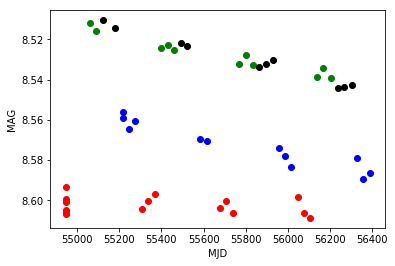

(281.06580062022897, 47.674570850003406, 'kplr2009114174833_ffi-cal.fits[15]')


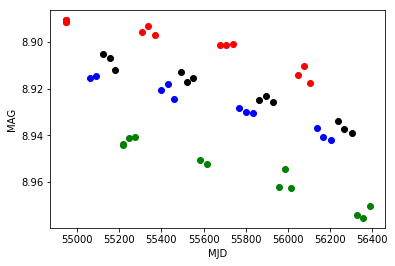

(289.86330415454705, 38.02818387052353, 'kplr2009114174833_ffi-cal.fits[29]')


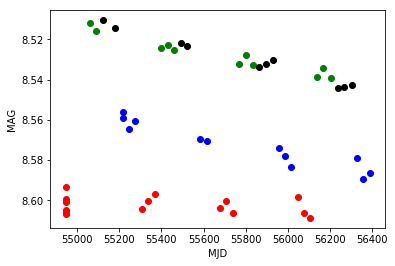

(281.0659413436924, 47.674820019383326, 'kplr2009114204835_ffi-cal.fits[15]')


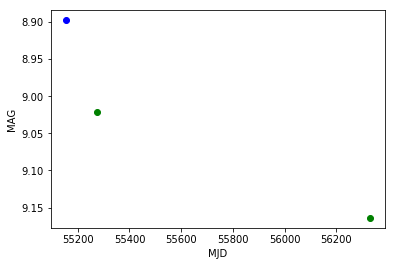

(292.5743879658267, 48.65116456063824, 'kplr2009322233047_ffi-cal.fits[25]')


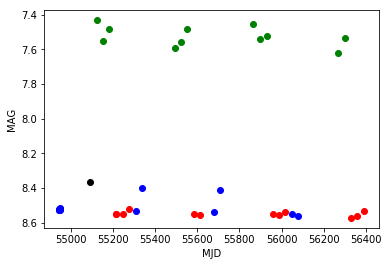

(293.2555181191914, 42.167597797237256, 'kplr2009322233047_ffi-cal.fits[39]')


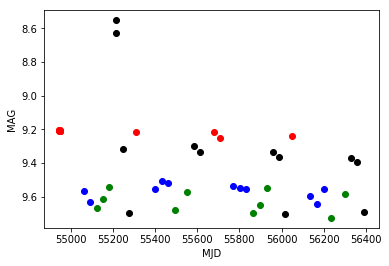

(284.4915861187469, 45.639227820339016, 'kplr2010019225502_ffi-cal.fits[28]')


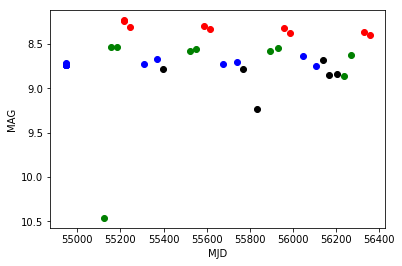

(288.44186318816713, 40.02411075963774, 'kplr2010019225502_ffi-cal.fits[65]')


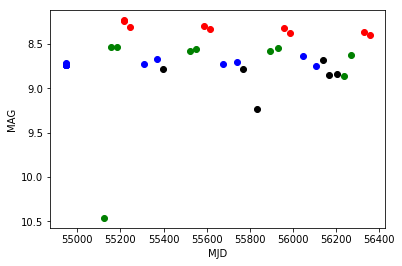

(288.44181487436686, 40.0241846061678, 'kplr2010020005046_ffi-cal.fits[65]')


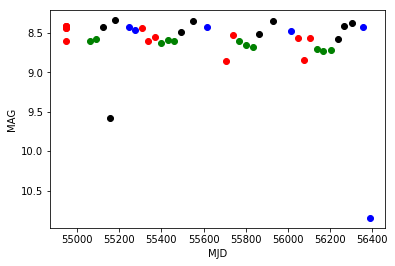

(282.03534530355205, 47.26822868719558, 'kplr2010111125026_ffi-cal.fits[15]')


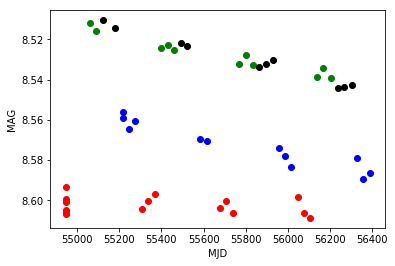

(281.0659413882968, 47.67459822763393, 'kplr2010140101631_ffi-cal.fits[15]')


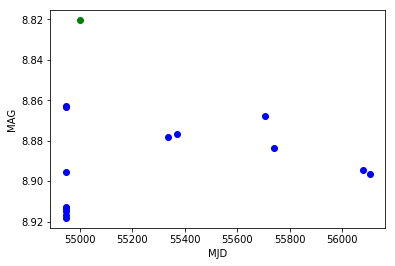

(291.8406505579973, 41.72720164556661, 'kplr2010140101631_ffi-cal.fits[45]')


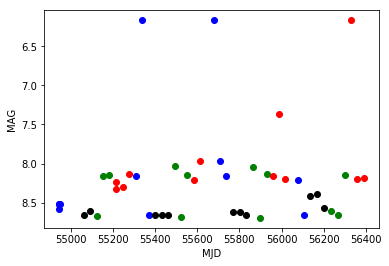

(285.0571639028919, 40.61492209666448, 'kplr2010234192745_ffi-cal.fits[34]')


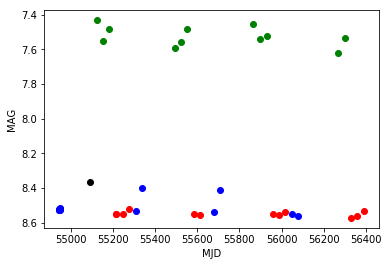

(293.2559333689719, 42.16739533280967, 'kplr2010326181728_ffi-cal.fits[39]')


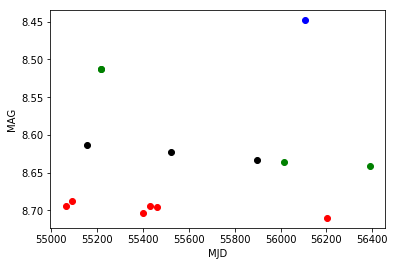

(285.91111034478854, 44.47348326142481, 'kplr2010326181728_ffi-cal.fits[66]')


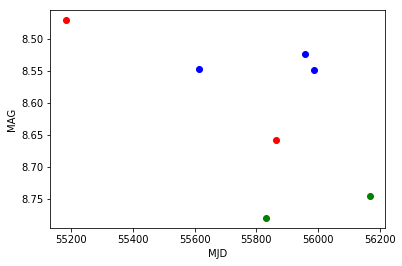

(285.3822757344309, 44.98637326566493, 'kplr2011053174401_ffi-cal.fits[26]')


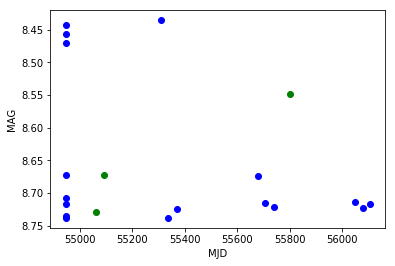

(295.30044838911095, 40.19813475404654, 'kplr2011177110110_ffi-cal.fits[50]')


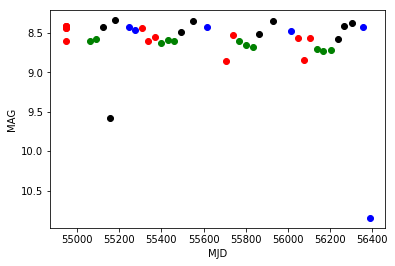

(282.0352651426848, 47.268911953801606, 'kplr2011240181752_ffi-cal.fits[75]')


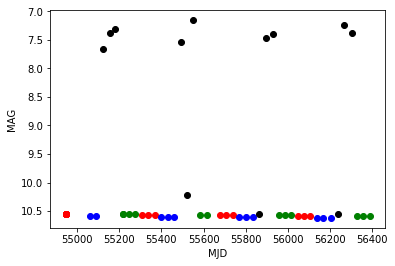

(295.04023677145346, 42.88009862622093, 'kplr2011334181008_ffi-cal.fits[17]')


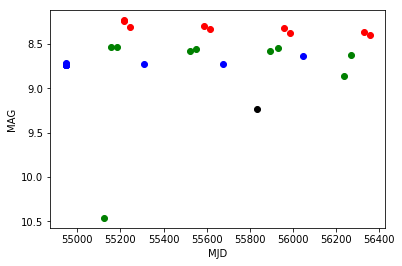

(288.44319323001105, 40.024516582336666, 'kplr2012121122500_ffi-cal.fits[25]')


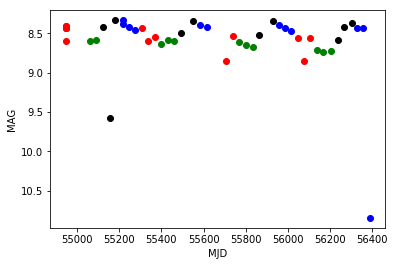

(282.0357171240712, 47.26918929870344, 'kplr2012151105138_ffi-cal.fits[15]')


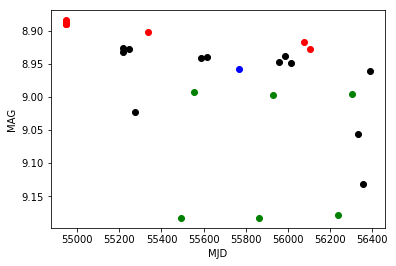

(289.65247405672727, 47.32778800607652, 'kplr2012151105138_ffi-cal.fits[37]')


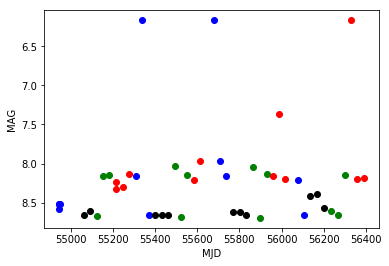

(285.05693607339543, 40.6146068424017, 'kplr2012242195726_ffi-cal.fits[34]')


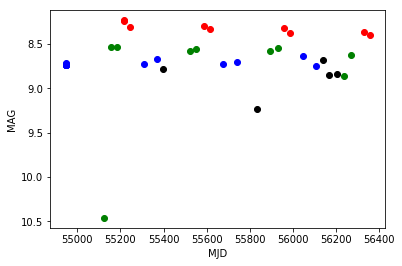

(288.4425853460137, 40.02334188034389, 'kplr2012310200152_ffi-cal.fits[57]')


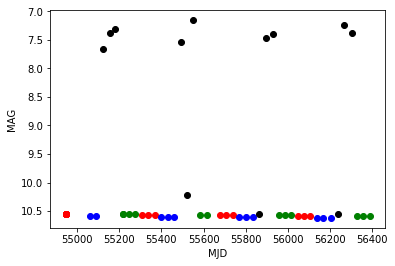

(295.0406644792216, 42.879860972498, 'kplr2012341215621_ffi-cal.fits[17]')


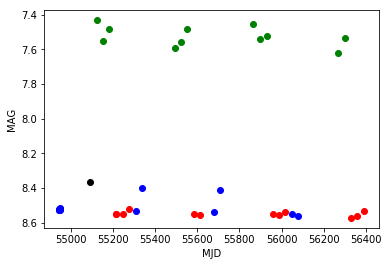

(293.25545320988607, 42.16653300167808, 'kplr2012341215621_ffi-cal.fits[39]')


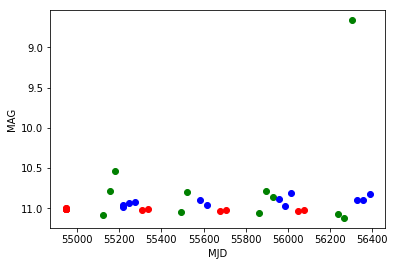

(291.5850787899832, 48.43674100940777, 'kplr2013011160902_ffi-cal.fits[27]')


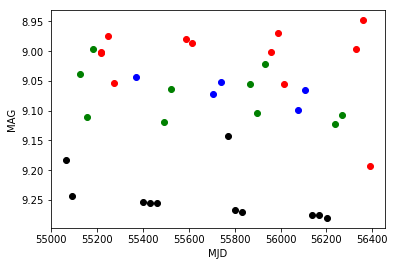

(281.5595290837081, 43.893302122615225, 'kplr2013065115251_ffi-cal.fits[29]')


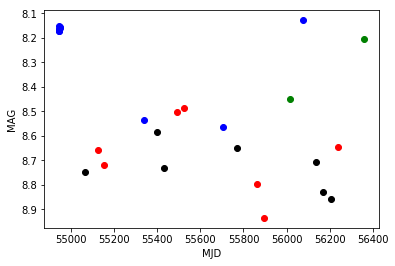

(293.62399242064873, 42.5367334023391, 'kplr2013065115251_ffi-cal.fits[62]')


In [22]:
isThereAmatch = [0 for x in mag]
colours = ['bo','go','ro','ko']
coloursAlt = ['b*','g*','r*','k*']
for x in range(len(datesfull)):
    if len(datesfull[x]) > 1:
        if isThereAmatch[x] ==0:
            for y in range(len(datesfull[x])):
                exts = list(set(fullExt[x]))
                #print(exts)
                pos = exts.index(fullExt[x][y])
                colour = colours[pos]
#                 print(pos)
#                 print(colour)
#                 print(len(datesfull[x]),len(mag[x]))
                plt.plot(datesfull[x][y],mag[x][y],colours[pos])
        else:
            for y in range(len(datesfull[x])):
                exts = list(set(fullExt[x]))
                pos = exts.index(fullExt[x][y])
                #print(exts)
                colour = colours[pos]
                plt.plot(datesfull[x][y],mag[x][y],coloursAlt[pos])
                
        plt.ylabel('MAG')
        plt.xlabel('MJD')
        plt.gca().invert_yaxis()
        #plt.legend()
        plt.show()
        print(origTab['RA'][x], origTab['DEC'][x],origTab['IMAGE_NAME'][x])

In [22]:
df = origTab.to_pandas()
df2 = df[df['RA'] == 285.72720076444773]
df2

,NUMBER,FLUX_BEST,FLUXERR_BEST,MAG_BEST,X_IMAGE,Y_IMAGE,ELLIPTICITY,RA,DEC,IMAGE_NAME,MEDIAN_NAME,DIFF_NAME,index,magDiff,MAG_BEST_ORIG,S/N,OBJECT INDEX
188,7,9528.476,26.68024,15.0524,481.5612,77.4627,0.298,285.727201,46.427704,kplr2009260000800_ffi-cal.fits[57],meidian_25_57.fits,diff_imNo14_channel25_ccd57.fits,35217,-1.215422,14.6233,77.63661,188


In [162]:
def makeDS9RegFile(sexTabList,fileNameBase,tabType,xcoords,ycoords):
#     for tables in range(len(sexTabList)):
#         if tabType == 'dao':
#             xcoords = sexTabList[tables]['xcentroid']
#             ycoords = sexTabList[tables]['ycentroid']
#         elif tabType == 'sex':
#             xcoords = sexTabList[tables]['X_IMAGE']
#             ycoords = sexTabList[tables]['Y_IMAGE']
#         elif tabType == 'iraf':
#             xcoords = sexTabList[tables]['X_POS']
#             ycoords = sexTabList[tables]['Y_POS']        
#         else:
#             print('tab type error')
#             break
        bigString = 'global color=lightgreen\nimage\n'
        for x in range(len(xcoords)):
            bigString += 'circle({},{},5)\n'.format(xcoords[x],ycoords[x])
        fileName = fileNameBase + '.reg'
        with open(fileName,'w') as f:
            f.write(bigString)
#         print(fileName)
#         print(os.listdir('.'))

In [161]:
ra = [origTab[]]
makeDS9RegFile(origTab,'/home/mj1e16/outTablesImproved/region','sex')
imagename = imageDirectory+origTab['IMAGE_NAME'][x]
subprocess.call(['ds9',imagename,'-r','/home/mj1e16/outTablesImproved/region.reg'])
#origTab['IMAGE_NAME']

TypeError: object of type 'numpy.float64' has no len()

In [147]:
for x in range(len(imNames)):
    if len(imNames[x]) > 1:
        dates = []
        for y in range(len(imNames[x])):
            image = imNames[x][y]
            #print(image)
            loc1 = image.find('[')
            loc2  = image.find(']')
            imagename = imageDirectory+image[:loc1]
            #print(imagename)
            pos = image[loc1+1:loc2]
            date = findDate(imagename,pos)
            dates.append(date)
        
        plt.plot(dates,mag[x],'o',label=str(x))
        plt.ylabel('MAG')
        plt.xlabel('MJD')
plt.legend()
plt.show()

KeyboardInterrupt: 

In [139]:
mag

[[15.7447],
 [16.2535],
 [15.9918],
 [10.4432, 10.4422, 10.4492, 10.4557, 10.4668],
 [12.5416,
  12.512,
  12.4601,
  12.4621,
  12.4663,
  12.5091,
  12.5084,
  12.4375,
  12.5062,
  12.5132,
  12.5099,
  12.5104,
  12.5151,
  12.539,
  12.5148,
  12.4673,
  12.4665,
  12.4671,
  12.47,
  12.4669,
  12.5197,
  12.5175,
  12.5167,
  12.5425,
  12.5419,
  12.5368,
  12.4758,
  12.4738,
  12.4432,
  12.4807,
  12.4806,
  12.4802,
  12.5285,
  12.5273,
  12.5462,
  12.5245,
  12.5448,
  12.4824,
  12.4823,
  12.4526,
  12.4906,
  12.4905,
  12.4893],
 [11.9721,
  11.9715,
  11.9721,
  11.9385,
  11.9492,
  11.9364,
  11.9475,
  11.9484,
  12.0273,
  12.0142,
  12.0176,
  12.0229,
  12.0213,
  12.0035,
  12.0038,
  12.0061,
  12.0068,
  12.0068,
  12.0068,
  12.0068,
  12.032,
  12.0073,
  12.0333,
  12.0226,
  12.0267,
  12.0258,
  12.0053,
  12.0071,
  12.0071,
  12.0071,
  12.0071,
  12.0367,
  12.0375,
  12.0359,
  12.0296,
  12.0347,
  12.0477,
  12.0094,
  12.0114,
  12.0153,
  12.01

In [104]:
allTabs[0]

NUMBER,FLUX_BEST,FLUXERR_BEST,MAG_BEST,X_IMAGE,Y_IMAGE,ELLIPTICITY,RA,DEC,IMAGE_NAME,OBJECT INDEX
int64,float64,float64,float64,float64,float64,float64,float64,float64,str30,int64
14,5036.469,65.64884,15.7447,429.82,25.2439,0.182,291.9074704436052,47.05886393568745,kplr2009114174833_ffi-cal.fits,13


In [100]:
testmatch

NUMBER,FLUX_BEST,FLUXERR_BEST,MAG_BEST,X_IMAGE,Y_IMAGE,ELLIPTICITY,RA,DEC,IMAGE_NAME,OBJECT INDEX
int64,float64,float64,float64,float64,float64,float64,float64,float64,str30,int64
14,5036.469,65.64884,15.7447,429.82,25.2439,0.182,291.9074704436052,47.05886393568745,kplr2009114174833_ffi-cal.fits,13


In [72]:
image = origTab['IMAGE_NAME'][0]
print(image)
loc1 = image.find('[')
loc2  = image.find(']')
print(loc1,loc2)
imagename = image[:loc1]
pos = image[loc1+1:loc2]
print(imagename,pos)

kplr2009114174833_ffi-cal.fits[58]
(30, 33)
('kplr2009114174833_ffi-cal.fits', '58')


In [65]:
subprocess.call(['ds9',imagelist[0]+'[{}]'.format(int(extensionOrders[0][1]))])

0

In [97]:
origTab

NUMBER,FLUX_BEST,FLUXERR_BEST,MAG_BEST,X_IMAGE,Y_IMAGE,ELLIPTICITY,RA,DEC,IMAGE_NAME,MEDIAN_NAME,DIFF_NAME,index,diffImage,medianImage,magDiff,MAG_BEST_ORIG,OBJECT INDEX
int64,float64,float64,float64,float64,float64,float64,float64,float64,str34,str18,str32,int64,str32,str18,float64,float64,int64
1,4972.103,37.4395,15.7586,429.9972,24.7407,0.351,291.9081476036849,47.058497168533194,kplr2009114174833_ffi-cal.fits[58],meidian_18_58.fits,diff_imNo11_channel18_ccd58.fits,122511,diff_imNo11_channel18_ccd58.fits,meidian_18_58.fits,-4.733674110651155,15.7447,0
159,2963.834,14.20312,16.3204,618.8993,260.8472,0.059,282.2997286819453,48.51511298543987,kplr2009115131122_ffi-cal.fits[16],meidian_12_16.fits,diff_imNo49_channel12_ccd16.fits,199471,diff_imNo49_channel12_ccd16.fits,meidian_12_16.fits,-3.0588167843178122,16.2535,1
31,2797.135,14.15697,16.3832,127.6044,916.9813,0.044,286.17639521590405,44.443401074095455,kplr2009115131122_ffi-cal.fits[18],meidian_26_18.fits,diff_imNo49_channel26_ccd18.fits,26660,diff_imNo49_channel26_ccd18.fits,meidian_26_18.fits,-4.250811469125403,16.3614,2
12,2862.116,37.76081,16.3583,1039.0616,993.9548,0.413,282.51787304188844,47.587614950317615,kplr2009260000800_ffi-cal.fits[76],meidian_12_76.fits,diff_imNo14_channel12_ccd76.fits,37135,diff_imNo14_channel12_ccd76.fits,meidian_12_76.fits,-4.9381187120948,16.3467,3
68,3784.545,39.92257,16.055,341.8187,226.6804,0.071,286.16801092086166,37.67179113909842,kplr2009351005245_ffi-cal.fits[75],meidian_71_75.fits,diff_imNo28_channel71_ccd75.fits,240247,diff_imNo28_channel71_ccd75.fits,meidian_71_75.fits,-3.5398002117672567,16.0125,4
118,3451.97,23.67002,16.1548,947.2881,593.7286,0.048,284.7198297858132,41.675149597439834,kplr2010020005046_ffi-cal.fits[49],meidian_49_49.fits,diff_imNo25_channel49_ccd49.fits,125109,diff_imNo25_channel49_ccd49.fits,meidian_49_49.fits,-5.09291635990458,16.1448,5
158,3651.136,36.02952,16.0939,645.012,273.612,0.114,294.896920769719,49.00664051747236,kplr2010078174524_ffi-cal.fits[13],meidian_13_13.fits,diff_imNo31_channel13_ccd13.fits,46525,diff_imNo31_channel13_ccd13.fits,meidian_13_13.fits,-4.209689270551595,16.0712,6
42,4922.818,28.08094,15.7695,847.0221,792.5739,0.006,283.1588141524291,47.39383732680302,kplr2010078174524_ffi-cal.fits[9],meidian_9_9.fits,diff_imNo31_channel9_ccd9.fits,152817,diff_imNo31_channel9_ccd9.fits,meidian_9_9.fits,-4.343615660343915,15.7494,7
5,1774.637,20.95655,16.8772,555.793,52.6379,0.11,282.85892686984414,46.1930525322328,kplr2010140101631_ffi-cal.fits[14],meidian_10_14.fits,diff_imNo21_channel10_ccd14.fits,259586,diff_imNo21_channel10_ccd14.fits,meidian_10_14.fits,-3.1725772265789005,16.8172,8


In [2]:
import os

In [8]:
a = os.listdir('/data/mj1e16/kepler/cal/')

In [6]:
a = [x for x in a if x == 'kplr2012121122500_ffi-cal.fits']

In [9]:
a.index('kplr2012121122500_ffi-cal.fits')

0

In [11]:
np.log10(5)

0.6989700043360189